In [3]:
import tensorflow as tf
from keras import layers, models
import numpy as np
import cv2
import os
from skimage import io, color
import os
import matplotlib.pyplot as plt
import random
from skimage import transform
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from keras.models import load_model
from tensorflow.keras.optimizers import Adam


# load dataset

In [3]:

# Plot the loss function
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# %%bash

# # Define source and target directories
# SOURCE_DIR="coco_dataset/test2017/"
# TARGET_DIR="coco_dataset/test2017_benchmark_10000/"
# # nb_imgs = 30000
# # Create the target directory if it doesn't exist
# mkdir -p "$TARGET_DIR"

# # Find the first 30,000 files in the source directory and move them to the target directory
# find "$SOURCE_DIR" -type f | head -n 10000 | while read file; do
#     mv "$file" "$TARGET_DIR"
# done

# echo "Moved the first 10000 images to $TARGET_DIR."


Moved the first 10000 images to coco_dataset/test2017_benchmark_10000/.


In [4]:
from pathlib import Path

# data_dir = 'coco_dataset/test2017_small_test/'
data_dir = 'coco_dataset/test2017_benchmark_10000/'

image_size = (256, 256)
batch_size = 4

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

def preprocess_for_colorization(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)
    print(grayscale.shape, image.shape)
    return grayscale/255.0, image/255.0
def preprocess_with_mask(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)
    print(image.shape)
    height, width = image.shape[1], image.shape[2]

    # Create a binary mask with 1% of pixels randomly set to 1
    num_pixels = height * width
    num_hints = int(0.01 * num_pixels) 
    flat_indices = tf.random.shuffle(tf.range(num_pixels))[:num_hints]
    binary_mask = tf.scatter_nd(
        indices=tf.expand_dims(flat_indices, axis=1),
        updates=tf.ones_like(flat_indices, dtype=tf.float32),
        shape=(num_pixels,)
    )
    binary_mask = tf.reshape(binary_mask, (height, width))  # Reshape to 2D

    # Expand binary mask to 3 channels and apply it to the original image
    binary_mask = tf.expand_dims(binary_mask, axis=-1)
    color_mask = image * tf.cast(binary_mask, dtype=image.dtype)

    grayscale = grayscale / 255.0
    color_mask = color_mask / 255.0
    image = image / 255.0
    return (grayscale, color_mask), image


# from skimage.color import rgb2lab, lab2lch
import tensorflow_io
from tensorflow_io.python.experimental.color_ops import rgb_to_lab
def preprocess_lab(image):

    image = tf.cast(image/255, tf.float32)
    lab = rgb_to_lab(image)
    l = lab[...,0]/100.0
    a = ( lab[...,1] + 128.0) /256.0
    b = ( lab[...,2] + 128.0) /256.0
    l = tf.expand_dims(l, axis=-1)
    a = tf.expand_dims(a, axis=-1)
    b = tf.expand_dims(b, axis=-1)
    ab = tf.concat([a,b], axis=-1)
    print(l.shape, ab.shape)
    return l, ab, l





Found 10000 files.


I0000 00:00:1734433906.985904  258446 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734433907.014272  258446 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734433907.014449  258446 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734433907.015231  258446 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
def psnr(y_true, y_pred):
    max_pixel = 1.0  
    # print(y_true.shape, y_pred.shape)
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

def ssim(y_true, y_pred):
    max_pixel = 1.0  
    return tf.image.ssim(y_true, y_pred, max_val=max_pixel)
import json
def save_loss(history, path):
    with open(path + ".json", 'w') as f:
        json.dump(history.history, f)

## prepeare data for RGB models

In [ ]:

colorization_dataset = dataset.map(preprocess_for_colorization, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_size = int(0.2 * len(list(Path(data_dir).glob('*')))) // batch_size
train_dataset = colorization_dataset.skip(val_size)
val_dataset = colorization_dataset.take(val_size)

# Ajouter des optimisations (mélange, préchargement)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
def display_from_dataset(dataset, num_images=5):
    plt.figure(figsize=(10, num_images * 3))
    count = 0
    for grayscale_batch, rgb_batch in dataset.take(1): 
        for i in range(num_images):
            if count >= len(grayscale_batch):  # Stop if fewer images than num_images in batch
                break
            grayscale_image = grayscale_batch[i].numpy().squeeze()  
            rgb_image = rgb_batch[i].numpy() 

            # Plot grayscale image
            plt.subplot(num_images, 2, 2 * count + 1)
            plt.imshow(grayscale_image, cmap='gray')
            plt.title("Grayscale Image")
            plt.axis("off")
            # Plot RGB image
            plt.subplot(num_images, 2, 2 * count + 2)
            plt.imshow(rgb_image)
            plt.title("RGB Image")
            plt.axis("off")

            count += 1
            if count >= num_images:
                break
    plt.show()

display_from_dataset(train_dataset, num_images=5)


In [6]:
from keras.callbacks import Callback

class SaveModelEveryNEpochs(Callback):
    def __init__(self, save_path, interval):
        super(SaveModelEveryNEpochs, self).__init__()
        self.save_path = save_path
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        # Save the model every 'interval' epochs
        if (epoch + 1) % self.interval == 0:
            save_path_with_epoch = f"{self.save_path}.keras"
            self.model.save(save_path_with_epoch)
            print(f"\nModel saved at {save_path_with_epoch}")


# Base Model

In [14]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, UpSampling2D, InputLayer, BatchNormalization, Input

def build_colorization_model(input_shape):
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    print(input_shape)
    # Encoder
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))

    # Decoder
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    return model

from keras.applications import VGG19

vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False  

feature_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv2').output)
def perceptual_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(feature_extractor(y_true) - feature_extractor(y_pred)))
    return loss






In [7]:
def train_model(model, save_path, save_loss_path, n_epochs, save_interval = 1):
    save_callback = SaveModelEveryNEpochs(save_path=save_path, interval=save_interval)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=n_epochs,
        callbacks=[save_callback]
    )
    save_loss(history, save_loss_path)


In [16]:
input_shape = (image_size[0], image_size[1], 1)  
model = build_colorization_model(input_shape)

model.compile(optimizer=Adam(learning_rate = 0.0005), loss = perceptual_loss, metrics=['mae', 'mse', psnr, ssim])
model.summary()

(256, 256, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,575,619 (17.45 MB)

 Trainable params: 4,575,619 (17.45 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
benchmark_epochs = 75

In [18]:
train_model(model, "rgb_model_256x256_75_epochs_perceptual_10000imgs_benchmark", "rgb_model_256x256_75_epochs_perceptual_10000imgs_benchmark_loss", benchmark_epochs)

Epoch 1/75


W0000 00:00:1734370228.352724  210369 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734370228.352777  210369 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1734370228.353977  210369 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1734370228.354035  210369 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1734370228.354299  210369 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1734370228.354482  210369 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.5224 - mae: 0.2521 - mse: 0.1078 - psnr: 10.7731 - ssim: 0.3022

W0000 00:00:1734370447.130511  210366 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734370447.130568  210366 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1734370447.131621  210366 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1734370447.131676  210366 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1734370447.131796  210366 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1734370447.131858  210366 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert



Model saved at rgb_model_256x256_75_epochs_perceptual_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 253s 123ms/step - loss: 0.5224 - mae: 0.2521 - mse: 0.1077 - psnr: 10.7738 - ssim: 0.3022 - val_loss: 0.2499 - val_mae: 0.1280 - val_mse: 0.0264 - val_psnr: 16.1551 - val_ssim: 0.5105
Epoch 2/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2194 - mae: 0.1199 - mse: 0.0249 - psnr: 16.5843 - ssim: 0.5468
Model saved at rgb_model_256x256_75_epochs_perceptual_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 246s 121ms/step - loss: 0.2194 - mae: 0.1199 - mse: 0.0249 - psnr: 16.5844 - ssim: 0.5468 - val_loss: 0.1961 - val_mae: 0.1132 - val_mse: 0.0221 - val_psnr: 17.0652 - val_ssim: 0.5666
Epoch 3/75
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1873 - mae: 0.1089 - mse: 0.0211 - psnr: 17.2886 - ssim: 0.5657
Model saved at rgb_model_256x256_75_epochs_perceptual_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 234s 115ms/step - loss: 0.1873 - mae: 

In [ ]:
# Compile the model
model_mse = build_colorization_model(input_shape)
model_mse.compile(optimizer=Adam(learning_rate = 0.0005), loss='mse', metrics=['mae', 'mse', psnr, ssim])
train_model(model_mse, "rgb_model_256x256_75_epochs_mse_10000imgs_benchmark", "rgb_model_256x256_75_epochs_mse_10000imgs_benchmark_loss", benchmark_epochs)

(256, 256, 1)
Epoch 1/75


W0000 00:00:1734387739.080504  210367 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734387739.081480  210367 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0203 - mae: 0.0995 - mse: 0.0203 - psnr: 18.2230 - ssim: 0.5214
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 99s 45ms/step - loss: 0.0203 - mae: 0.0995 - mse: 0.0203 - psnr: 18.2237 - ssim: 0.5214 - val_loss: 0.0130 - val_mae: 0.0799 - val_mse: 0.0130 - val_psnr: 19.7369 - val_ssim: 0.6374
Epoch 2/75
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0121 - mae: 0.0754 - mse: 0.0121 - psnr: 20.1026 - ssim: 0.6516
Model saved at rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step - loss: 0.0121 - mae: 0.0754 - mse: 0.0121 - psnr: 20.1026 - ssim: 0.6516 - val_loss: 0.0113 - val_mae: 0.0733 - val_mse: 0.0113 - val_psnr: 20.4111 - val_ssim: 0.6842
Epoch 3/75
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0116 - mae: 0.0736 - mse: 0.0116 - psnr: 20.3336 - ssim: 0.6819
Model saved at rgb_model_256x256_75_epochs_mse_10000

# Evaluate Model 

In [12]:



from pathlib import Path

# data_dir = 'coco_dataset/val2017_subset/'
data_dir = 'test2017/'

image_size = (256, 256)
batch_size = 8

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)


colorization_dataset = dataset.map(preprocess_for_colorization, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# colorization_dataset = dataset.map(preprocess_with_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_size = int(0.2 * len(list(Path(data_dir).glob('*')))) // batch_size
train_dataset = colorization_dataset.skip(val_size)
val_dataset = colorization_dataset.take(val_size)

# Ajouter des optimisations (mélange, préchargement)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)




# Charger une image grayscale pour prédiction
def load_grayscale_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)  
    image = tf.image.resize(image, target_size) / 255.0  
    return tf.expand_dims(image, axis=0)  


def prediction_examples(model, data):
    for grayscale_batch, rgb_batch in data.take(1):
        predicted_rgb = model.predict(grayscale_batch)
        # Initialize PSNR and SSIM lists
        psnr_scores = []
        ssim_scores = []
        plt.figure(figsize=(15, 10))
        for i in range(5):  # Display 5 examples
            true_image = rgb_batch[i].numpy()
            pred_image = np.clip(predicted_rgb[i], 0, 1)  # Ensure predictions are in [0, 1]
            psnr = peak_signal_noise_ratio(true_image, pred_image, data_range=1)
            ssim = structural_similarity(
                true_image, 
                pred_image, 
                channel_axis=-1, 
                data_range=1, 
                win_size=3  
            )
            psnr_scores.append(psnr)
            ssim_scores.append(ssim)

            plt.subplot(4, 5, i + 1)
            plt.title("Grayscale")
            plt.imshow(grayscale_batch[i].numpy().squeeze(), cmap='gray')
            plt.axis('off')

            plt.subplot(4, 5, i + 6)
            plt.title("True RGB")
            plt.imshow(true_image)
            plt.axis('off')

            plt.subplot(4, 5, i + 11)
            plt.title("Predicted RGB")
            plt.imshow(pred_image)
            plt.axis('off')

            plt.subplot(4, 5, i + 16)
            plt.title(f"PSNR: {psnr:.2f}\nSSIM: {ssim:.2f}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        print(f"Average PSNR: {np.mean(psnr_scores):.2f}")
        print(f"Average SSIM: {np.mean(ssim_scores):.2f}")



Found 40670 files.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


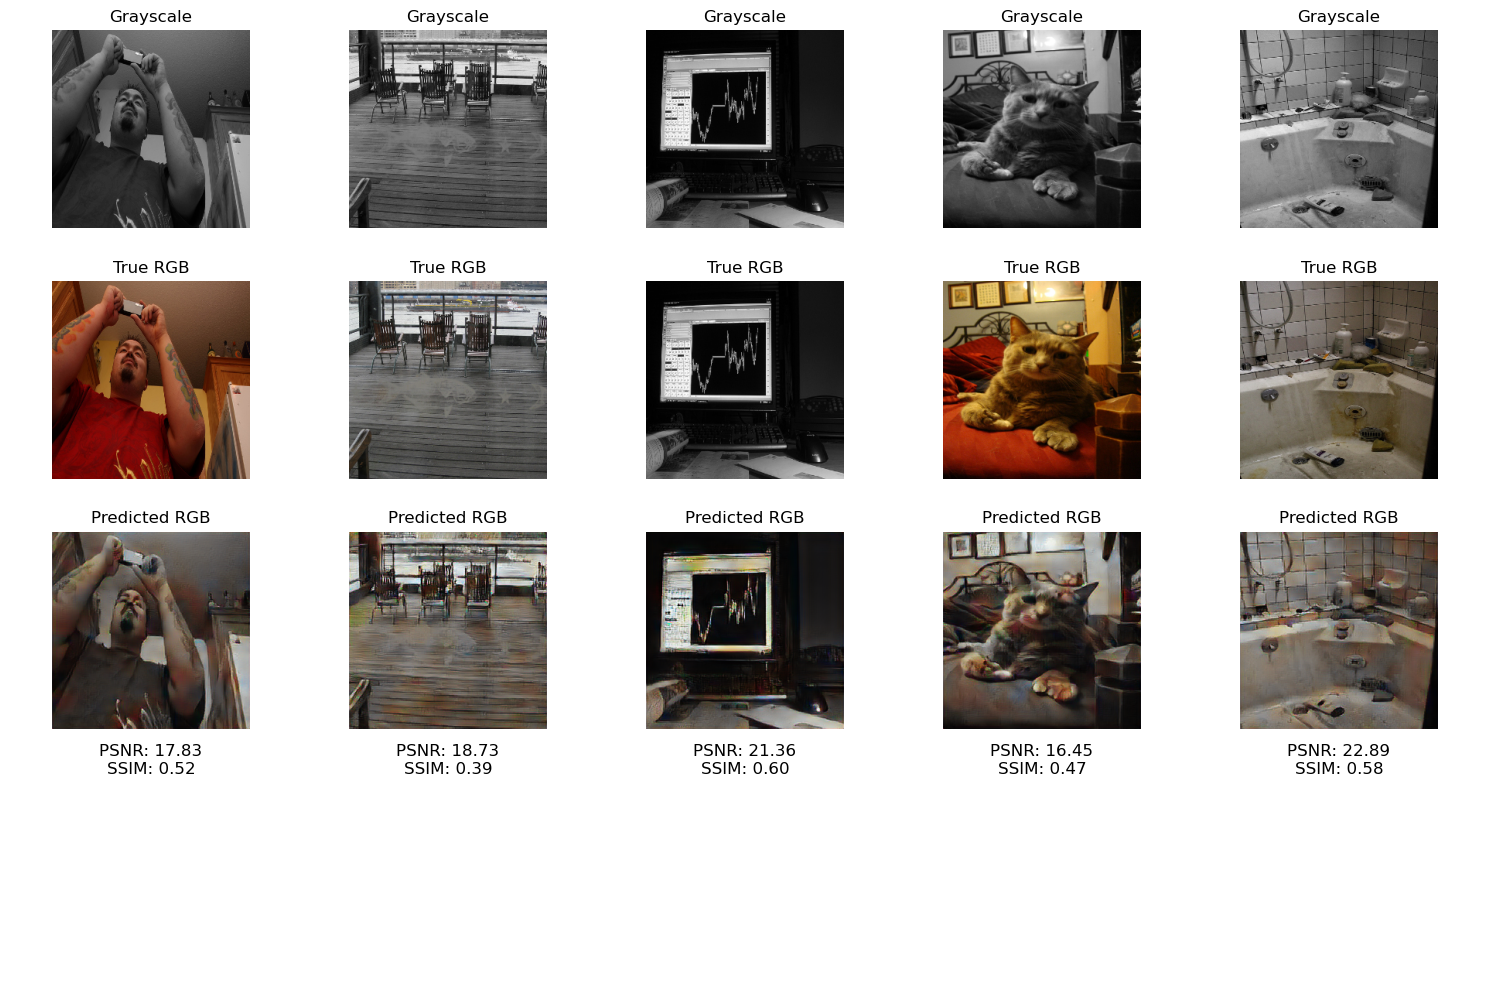

Average PSNR: 19.45
Average SSIM: 0.51


In [28]:
prediction_examples(saved_model, val_dataset)

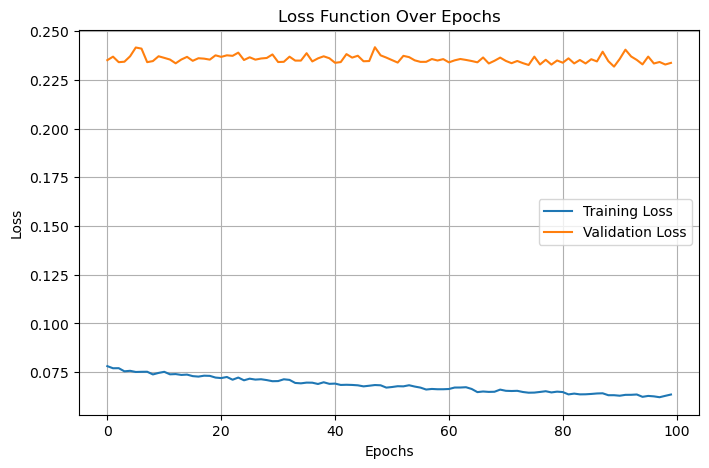

In [39]:

# Plot the loss function
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)

In [19]:

def evaluate_model_on_validation(model, val_data):
    psnr_scores = []
    ssim_scores = []

    # Iterate over the entire validation dataset
    for grayscale_batch, rgb_batch in val_data:
        predicted_batch = model.predict(grayscale_batch)
        # Iterate through the batch
        for i in range(grayscale_batch.shape[0]):  
            true_image = rgb_batch[i].numpy()
            pred_image = np.clip(predicted_batch[i], 0, 1) 
            psnr = peak_signal_noise_ratio(true_image, pred_image, data_range=1)
            ssim = structural_similarity(
                true_image, 
                pred_image, 
                channel_axis=-1, 
                data_range=1, 
                win_size=3  
            )

            psnr_scores.append(psnr)
            ssim_scores.append(ssim)
    mean_psnr = np.mean(psnr_scores)
    mean_ssim = np.mean(ssim_scores)
    print(f"Mean PSNR: {mean_psnr:.2f}")
    print(f"Mean SSIM: {mean_ssim:.2f}")

    return mean_psnr, mean_ssim

In [20]:
evaluate_model_on_validation(saved_model, val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

(18.658084515641534, 0.5004011)

# Other Metrics than PSNR and SSIM

# Model with Mask

In [ ]:
import matplotlib.pyplot as plt

def display_sample_images_with_mask(dataset, num_samples=5):
    """Displays a few examples of grayscale images, masks, and original images."""
    for (grayscale, mask), original in dataset.take(num_samples):
        for i in range(min(num_samples, grayscale.shape[0])):  # Handle batch
            # Convert tensors to numpy arrays
            grayscale_img = grayscale[i].numpy().squeeze()  # (128, 128, 1) -> (128, 128)
            mask_img = mask[i].numpy()
            original_img = original[i].numpy()

            # Plot the images
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Grayscale")
            plt.imshow(grayscale_img, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title("Mask")
            plt.imshow(mask_img)
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title("Original")
            plt.imshow(original_img)
            plt.axis('off')

            plt.tight_layout()
            plt.show()

# Call the function on the dataset
display_sample_images_with_mask(colorization_dataset)


In [ ]:
from keras.layers import Concatenate, Input
from keras.models import Sequential, Model
from keras.layers import Conv2D, UpSampling2D, InputLayer, BatchNormalization, Input
from keras.applications import VGG19
def build_colorization_model_with_mask(input_shape):
    # Inputs
    grayscale_input = Input(shape=input_shape, name="grayscale_input")  # (128, 128, 1)
    mask_input = Input(shape=(input_shape[0], input_shape[1], 3), name="mask_input")  # (128, 128, 3)

    # Concatenate grayscale and mask
    x = Concatenate()([grayscale_input, mask_input])  # (128, 128, 4)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Final colorized output

    model = Model(inputs=[grayscale_input, mask_input], outputs=output)
    return model


In [ ]:
input_shape = (image_size[0], image_size[1], 1)  # Grayscale images have 1 channel
# Rebuild the model with the new input
model_mask = build_colorization_model_with_mask(input_shape)
model_mask.summary()
# Compile the model
model_mask.compile(optimizer='adam', loss= 'mse', metrics=['mae'])




In [ ]:
# Train the model
history = model_mask.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

In [ ]:
def predict_with_mask(model, grayscale_image, mask):
    grayscale_image = np.expand_dims(grayscale_image, axis=0)  
    mask = np.expand_dims(mask, axis=0)  
    prediction = model.predict([grayscale_image, mask])
    return prediction[0]  


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def predict_and_visualize(model, dataset):
    """Predicts and visualizes the results on a batch of data."""
    for (grayscale_batch, mask_batch), true_rgb_batch in dataset.take(1):
        predicted_rgb_batch = model.predict([grayscale_batch, mask_batch])

        psnr_scores = []
        ssim_scores = []

        plt.figure(figsize=(15, 10))

        # Display 5 examples
        for i in range(min(5, grayscale_batch.shape[0])):
            grayscale_image = grayscale_batch[i].numpy().squeeze()  # (128, 128, 1) -> (128, 128)
            mask_image = mask_batch[i].numpy()  # (128, 128, 3)
            true_rgb_image = true_rgb_batch[i].numpy()  # (128, 128, 3)
            predicted_rgb_image = np.clip(predicted_rgb_batch[i], 0, 1)  # (128, 128, 3)

            # Compute metrics
            psnr = peak_signal_noise_ratio(true_rgb_image, predicted_rgb_image, data_range=1)
            ssim = structural_similarity(
                true_rgb_image,
                predicted_rgb_image,
                channel_axis=-1,
                data_range=1,
                win_size=3
            )
            psnr_scores.append(psnr)
            ssim_scores.append(ssim)

            plt.subplot(5, 5, i + 1)
            plt.title("Grayscale")
            plt.imshow(grayscale_image, cmap='gray')
            plt.axis('off')

            plt.subplot(5, 5, i + 6)
            plt.title("Hint Mask")
            plt.imshow(mask_image)
            plt.axis('off')

            plt.subplot(5, 5, i + 11)
            plt.title("True RGB")
            plt.imshow(true_rgb_image)
            plt.axis('off')

            plt.subplot(5, 5, i + 16)
            plt.title("Predicted RGB")
            plt.imshow(predicted_rgb_image)
            plt.axis('off')

            plt.subplot(5, 5, i + 21)
            plt.title(f"PSNR: {psnr:.2f}\nSSIM: {ssim:.2f}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        print(f"Average PSNR: {np.mean(psnr_scores):.2f}")
        print(f"Average SSIM: {np.mean(ssim_scores):.2f}")
        break  


In [ ]:
predict_and_visualize(model_mask, colorization_dataset)


In [ ]:
def evaluate_model_on_validation(model, val_data):
    psnr_scores = []
    ssim_scores = []

    # Iterate over the entire validation dataset
    for (grayscale_batch, mask_batch), rgb_batch in val_data:
        # Predict using the model
        predicted_batch = model.predict([grayscale_batch, mask_batch])

        # Iterate through the batch
        for i in range(grayscale_batch.shape[0]):
            true_image = rgb_batch[i].numpy()  # Ground truth
            pred_image = np.clip(predicted_batch[i], 0, 1)  # Ensure predictions are in [0, 1]

            # Compute PSNR and SSIM
            psnr = peak_signal_noise_ratio(true_image, pred_image, data_range=1)
            ssim = structural_similarity(
                true_image,
                pred_image,
                channel_axis=-1,
                data_range=1,
                win_size=3
            )

            # Append scores
            psnr_scores.append(psnr)
            ssim_scores.append(ssim)

    # Compute mean scores
    mean_psnr = np.mean(psnr_scores)
    mean_ssim = np.mean(ssim_scores)

    print(f"Mean PSNR: {mean_psnr:.2f}")
    print(f"Mean SSIM: {mean_ssim:.2f}")

    return mean_psnr, mean_ssim


# Lab model

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate


def create_lab_colorization_model_with_batch_norm():
    input_l = Input(shape=(input_shape[0], input_shape[1], 1), name="Input_L")

    # Encoder 
    x1 = Conv2D(64, (3, 3), padding="same", strides=1)(input_l)
    x1 = BatchNormalization()(x1) 
    x1 = tf.keras.layers.Activation("relu")(x1)

    x2 = Conv2D(128, (3, 3), padding="same", strides=2)(x1)  
    x2 = BatchNormalization()(x2)  
    x2 = tf.keras.layers.Activation("relu")(x2)

    x3 = Conv2D(256, (3, 3), padding="same", strides=2)(x2)  
    x3 = BatchNormalization()(x3)  
    x3 = tf.keras.layers.Activation("relu")(x3)

    x4 = Conv2D(512, (3, 3), padding="same", strides=2)(x3) 
    x4 = BatchNormalization()(x4)  
    x4 = tf.keras.layers.Activation("relu")(x4)

    # Decoder (upsampling)
    x5 = UpSampling2D((2, 2))(x4) 
    x5 = Concatenate()([x5, x3]) 
    x5 = Conv2D(256, (3, 3), padding="same")(x5)
    x5 = BatchNormalization()(x5) 
    x5 = tf.keras.layers.Activation("relu")(x5)

    x6 = UpSampling2D((2, 2))(x5) 
    x6 = Concatenate()([x6, x2]) 
    x6 = Conv2D(128, (3, 3), padding="same")(x6)
    x6 = BatchNormalization()(x6) 
    x6 = tf.keras.layers.Activation("relu")(x6)

    x7 = UpSampling2D((2, 2))(x6)  
    x7 = Concatenate()([x7, x1])  
    x7 = Conv2D(64, (3, 3), padding="same")(x7)
    x7 = BatchNormalization()(x7)  
    x7 = tf.keras.layers.Activation("relu")(x7)

    ab_output = Conv2D(2, (1, 1), activation="sigmoid", name="Output_ab")(x7)
    model = Model(inputs=input_l, outputs=ab_output, name="Lab_Colorization_Model_With_Batch_Norm")
    return model




In [9]:
colorization_dataset = dataset.map(preprocess_lab, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_size = int(0.2 * len(list(Path(data_dir).glob('*')))) // batch_size
train_dataset = colorization_dataset.skip(val_size)
val_dataset = colorization_dataset.take(val_size)

# Ajouter des optimisations (mélange, préchargement)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

(None, 256, 256, 1) (None, 256, 256, 2)


In [39]:
# Set the input shape
input_shape = (image_size[0], image_size[1], 1)
model_lab_bn = create_lab_colorization_model_with_batch_norm()
model_lab_bn.summary()

Model: "Lab_Colorization_Model_With_Batch_Norm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_L             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 256, 256,  │        640 │ Input_L[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_7[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 64, 64,    │    295,168 │ activation_8[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ activation_9[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_15    │ (None, 64, 64,    │          0 │ activation_10[0]… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 64, 64,    │          0 │ up_sampling2d_15… │
│ (Concatenate)       │ 768)              │            │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │  1,769,728 │ concatenate_15[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_38[0][0] 

 Total params: 3,878,466 (14.80 MB)

 Trainable params: 3,875,650 (14.78 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
# model_lab_bn.save("colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm_backup.keras")

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
# # Now train the model
# from tensorflow.keras.optimizers import Adam
# model_lab_bn.compile(optimizer= Adam(learning_rate = 0.00002), loss='mse', metrics=['mae'])
# early_stop = EarlyStopping(monitor='loss',patience=15)
# # Define the model save path and interval
# save_path = "colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm_benchmark"
# # save_interval = 4

# # save_callback_lab_bn = SaveModelEveryNEpochs(save_path=save_path, interval=save_interval)

# # history_lab_bn = model_lab_bn.fit(
# #     train_dataset,  # Only pass the dataset here
# #     validation_data=val_dataset,
# #     epochs=75,
# #     callbacks = [save_callback_lab_bn , early_stop]
# # )


Epoch 1/75


2024-12-14 15:23:42.695047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 315 of 1000
2024-12-14 15:23:47.812867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0063 - mae: 0.0541Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 272s 63ms/step - loss: 0.0063 - mae: 0.0541 - val_loss: 0.0032 - val_mae: 0.0379
Epoch 2/75


2024-12-14 15:28:11.885167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 245 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:27:12 17s/step - loss: 0.0027 - mae: 0.0360

2024-12-14 15:28:18.318858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0032 - mae: 0.0386Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 268s 63ms/step - loss: 0.0032 - mae: 0.0386 - val_loss: 0.0031 - val_mae: 0.0377
Epoch 3/75


2024-12-14 15:32:40.343964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 242 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 4:03 61ms/step - loss: 0.0043 - mae: 0.0449   

2024-12-14 15:32:46.799232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0032 - mae: 0.0382Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 268s 63ms/step - loss: 0.0032 - mae: 0.0382 - val_loss: 0.0031 - val_mae: 0.0373
Epoch 4/75


2024-12-14 15:37:08.401901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 236 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:59:01 17s/step - loss: 0.0041 - mae: 0.0446

2024-12-14 15:37:15.269334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0031 - mae: 0.0378Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 267s 63ms/step - loss: 0.0031 - mae: 0.0378 - val_loss: 0.0031 - val_mae: 0.0377
Epoch 5/75


2024-12-14 15:41:35.459752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 114 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 19:55:00 18s/step - loss: 0.0068 - mae: 0.0504

2024-12-14 15:41:43.185334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0031 - mae: 0.0375Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 268s 63ms/step - loss: 0.0031 - mae: 0.0375 - val_loss: 0.0030 - val_mae: 0.0375
Epoch 6/75


2024-12-14 15:46:03.458978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 188 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:54:43 17s/step - loss: 0.0015 - mae: 0.0277

2024-12-14 15:46:10.238457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0030 - mae: 0.0372Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 266s 62ms/step - loss: 0.0030 - mae: 0.0372 - val_loss: 0.0030 - val_mae: 0.0371
Epoch 7/75


2024-12-14 15:50:29.092746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 128 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:53 58ms/step - loss: 0.0040 - mae: 0.0422   

2024-12-14 15:50:36.443954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0031 - mae: 0.0373Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 266s 62ms/step - loss: 0.0031 - mae: 0.0373 - val_loss: 0.0030 - val_mae: 0.0368
Epoch 8/75


2024-12-14 15:54:55.455951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 144 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 19:27:58 18s/step - loss: 0.0044 - mae: 0.0460

2024-12-14 15:55:02.722456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0030 - mae: 0.0370Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 265s 62ms/step - loss: 0.0030 - mae: 0.0370 - val_loss: 0.0030 - val_mae: 0.0365
Epoch 9/75


2024-12-14 15:59:20.476039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 140 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 19:46:06 18s/step - loss: 0.0020 - mae: 0.0330

2024-12-14 15:59:28.065788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0030 - mae: 0.0369Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 268s 62ms/step - loss: 0.0030 - mae: 0.0369 - val_loss: 0.0030 - val_mae: 0.0376
Epoch 10/75


2024-12-14 16:03:48.161774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 182 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:54 59ms/step - loss: 0.0033 - mae: 0.0399   

2024-12-14 16:03:55.301211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0029 - mae: 0.0366Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 265s 62ms/step - loss: 0.0029 - mae: 0.0366 - val_loss: 0.0030 - val_mae: 0.0368
Epoch 11/75


2024-12-14 16:08:13.633131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 183 of 1000
2024-12-14 16:08:20.524482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0030 - mae: 0.0369Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 265s 62ms/step - loss: 0.0030 - mae: 0.0369 - val_loss: 0.0031 - val_mae: 0.0383
Epoch 12/75


2024-12-14 16:12:39.055328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 121 of 1000
2024-12-14 16:12:46.533293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0030 - mae: 0.0369Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 269s 63ms/step - loss: 0.0030 - mae: 0.0369 - val_loss: 0.0030 - val_mae: 0.0368
Epoch 13/75


2024-12-14 16:17:07.780473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 183 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 19:14:08 17s/step - loss: 0.0015 - mae: 0.0284

2024-12-14 16:17:14.927769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0029 - mae: 0.0365Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 269s 63ms/step - loss: 0.0029 - mae: 0.0365 - val_loss: 0.0030 - val_mae: 0.0372
Epoch 14/75


2024-12-14 16:21:36.808530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 182 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 19:19:14 17s/step - loss: 0.0035 - mae: 0.0410

2024-12-14 16:21:43.938757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0029 - mae: 0.0365Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 259s 60ms/step - loss: 0.0029 - mae: 0.0365 - val_loss: 0.0030 - val_mae: 0.0367
Epoch 15/75


2024-12-14 16:25:55.492817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 211 of 1000
2024-12-14 16:26:02.248397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0366Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0029 - mae: 0.0366 - val_loss: 0.0029 - val_mae: 0.0361
Epoch 16/75


2024-12-14 16:30:08.939047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 192 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:36 54ms/step - loss: 0.0041 - mae: 0.0455   

2024-12-14 16:30:16.010484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3999/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0365Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 0.0029 - mae: 0.0365 - val_loss: 0.0030 - val_mae: 0.0364
Epoch 17/75


2024-12-14 16:34:22.844290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 192 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 19:02:55 17s/step - loss: 0.0041 - mae: 0.0436

2024-12-14 16:34:29.660313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0365Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 0.0029 - mae: 0.0365 - val_loss: 0.0030 - val_mae: 0.0362
Epoch 18/75


2024-12-14 16:38:36.463919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 204 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:54:23 17s/step - loss: 0.0020 - mae: 0.0281

2024-12-14 16:38:43.256812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0362Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 0.0029 - mae: 0.0362 - val_loss: 0.0029 - val_mae: 0.0361
Epoch 19/75


2024-12-14 16:42:50.011204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 172 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:44 56ms/step - loss: 0.0019 - mae: 0.0282   

2024-12-14 16:42:57.060380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0362Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 0.0029 - mae: 0.0362 - val_loss: 0.0030 - val_mae: 0.0366
Epoch 20/75


2024-12-14 16:47:03.550373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 212 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:47:18 17s/step - loss: 0.0056 - mae: 0.0521

2024-12-14 16:47:10.247355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0362Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0029 - mae: 0.0362 - val_loss: 0.0030 - val_mae: 0.0371
Epoch 21/75


2024-12-14 16:51:16.674153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 202 of 1000
2024-12-14 16:51:23.470366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0363Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0029 - mae: 0.0363 - val_loss: 0.0031 - val_mae: 0.0377
Epoch 22/75


2024-12-14 16:55:29.988039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 225 of 1000
2024-12-14 16:55:36.603310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0361Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0029 - mae: 0.0361 - val_loss: 0.0029 - val_mae: 0.0361
Epoch 23/75


2024-12-14 16:59:43.006185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 216 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:31:34 17s/step - loss: 0.0029 - mae: 0.0379

2024-12-14 16:59:49.551979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0360Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0029 - mae: 0.0360 - val_loss: 0.0030 - val_mae: 0.0362
Epoch 24/75


2024-12-14 17:03:56.058272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 205 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:43 56ms/step - loss: 0.0023 - mae: 0.0338   

2024-12-14 17:04:02.765042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0360Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0029 - mae: 0.0360 - val_loss: 0.0029 - val_mae: 0.0363
Epoch 25/75


2024-12-14 17:08:09.274861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 230 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:46 57ms/step - loss: 0.0037 - mae: 0.0426   

2024-12-14 17:08:15.746598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0362Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0029 - mae: 0.0362 - val_loss: 0.0029 - val_mae: 0.0358
Epoch 26/75


2024-12-14 17:12:22.295491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 276 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:46 57ms/step - loss: 0.0024 - mae: 0.0322   

2024-12-14 17:12:28.362051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0359Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0029 - mae: 0.0359 - val_loss: 0.0029 - val_mae: 0.0366
Epoch 27/75


2024-12-14 17:16:34.824357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 204 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:43:34 17s/step - loss: 0.0042 - mae: 0.0477

2024-12-14 17:16:41.455560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0361Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0029 - mae: 0.0361 - val_loss: 0.0030 - val_mae: 0.0369
Epoch 28/75


2024-12-14 17:20:47.933496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 219 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:32:43 17s/step - loss: 0.0015 - mae: 0.0278

2024-12-14 17:20:54.432554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0358Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0358 - val_loss: 0.0031 - val_mae: 0.0381
Epoch 29/75


2024-12-14 17:25:00.903921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 179 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 19:00:31 17s/step - loss: 0.0045 - mae: 0.0490

2024-12-14 17:25:07.862412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0029 - mae: 0.0361Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0029 - mae: 0.0361 - val_loss: 0.0030 - val_mae: 0.0367
Epoch 30/75


2024-12-14 17:29:14.431536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 238 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:19:09 16s/step - loss: 0.0026 - mae: 0.0393

2024-12-14 17:29:20.702805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0359Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0359 - val_loss: 0.0029 - val_mae: 0.0359
Epoch 31/75


2024-12-14 17:33:27.190224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 219 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:46 57ms/step - loss: 0.0022 - mae: 0.0317   

2024-12-14 17:33:33.683982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0358Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0358 - val_loss: 0.0029 - val_mae: 0.0357
Epoch 32/75


2024-12-14 17:37:40.258273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 215 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0024 - mae: 0.03390.0339

2024-12-14 17:37:46.773294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0359Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0359 - val_loss: 0.0030 - val_mae: 0.0363
Epoch 33/75


2024-12-14 17:41:53.297054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 207 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:49 58ms/step - loss: 0.0055 - mae: 0.0494   

2024-12-14 17:41:59.904822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0357Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0357 - val_loss: 0.0029 - val_mae: 0.0358
Epoch 34/75


2024-12-14 17:46:06.536188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 192 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:50 58ms/step - loss: 0.0020 - mae: 0.0313   

2024-12-14 17:46:13.350500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0356Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 0.0028 - mae: 0.0356 - val_loss: 0.0029 - val_mae: 0.0364
Epoch 35/75


2024-12-14 17:50:20.123679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 216 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:42 56ms/step - loss: 0.0021 - mae: 0.0307   

2024-12-14 17:50:26.696750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0358Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0358 - val_loss: 0.0030 - val_mae: 0.0364
Epoch 36/75


2024-12-14 17:54:33.534574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 202 of 1000
2024-12-14 17:54:40.240696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3999/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0357Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0357 - val_loss: 0.0029 - val_mae: 0.0361
Epoch 37/75


2024-12-14 17:58:47.008954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 238 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:46 57ms/step - loss: 0.0021 - mae: 0.0303   

2024-12-14 17:58:53.697798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0355Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0355 - val_loss: 0.0029 - val_mae: 0.0361
Epoch 38/75


2024-12-14 18:03:00.530279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 245 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:50 58ms/step - loss: 0.0017 - mae: 0.0263   

2024-12-14 18:03:06.946146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0356Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0356 - val_loss: 0.0029 - val_mae: 0.0358
Epoch 39/75


2024-12-14 18:07:13.685639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 180 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:56:08 17s/step - loss: 0.0010 - mae: 0.0228

2024-12-14 18:07:20.561869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0354Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 0.0028 - mae: 0.0354 - val_loss: 0.0029 - val_mae: 0.0358
Epoch 40/75


2024-12-14 18:11:27.313350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 224 of 1000
2024-12-14 18:11:33.780339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0354Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0354 - val_loss: 0.0030 - val_mae: 0.0371
Epoch 41/75


2024-12-14 18:15:40.530310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 240 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:40:21 17s/step - loss: 0.0046 - mae: 0.0477

2024-12-14 18:15:47.184391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0354Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0354 - val_loss: 0.0029 - val_mae: 0.0366
Epoch 42/75


2024-12-14 18:19:53.952643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 174 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 19:00:19 17s/step - loss: 0.0036 - mae: 0.0413

2024-12-14 18:20:00.841340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0354Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 0.0028 - mae: 0.0354 - val_loss: 0.0030 - val_mae: 0.0366
Epoch 43/75


2024-12-14 18:24:07.533000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 214 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:28:49 17s/step - loss: 0.0016 - mae: 0.0281

2024-12-14 18:24:14.038846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0357Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0357 - val_loss: 0.0029 - val_mae: 0.0363
Epoch 44/75


2024-12-14 18:28:20.767210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 235 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:32:59 17s/step - loss: 0.0020 - mae: 0.0318

2024-12-14 18:28:27.233600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0355Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0355 - val_loss: 0.0029 - val_mae: 0.0360
Epoch 45/75


2024-12-14 18:32:34.036175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 283 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:49 57ms/step - loss: 0.0019 - mae: 0.0301   

2024-12-14 18:32:40.264398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0355Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0355 - val_loss: 0.0029 - val_mae: 0.0360
Epoch 46/75


2024-12-14 18:36:46.999374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 205 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:43:40 17s/step - loss: 0.0036 - mae: 0.0440

2024-12-14 18:36:53.668405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0355Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0355 - val_loss: 0.0029 - val_mae: 0.0354
Epoch 47/75


2024-12-14 18:41:00.364489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 251 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:19:26 16s/step - loss: 0.0017 - mae: 0.0277

2024-12-14 18:41:06.701802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0352Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0352 - val_loss: 0.0029 - val_mae: 0.0356
Epoch 48/75


2024-12-14 18:45:13.433311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 196 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:31 53ms/step - loss: 0.0016 - mae: 0.0291   

2024-12-14 18:45:20.195862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0354Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 0.0028 - mae: 0.0354 - val_loss: 0.0029 - val_mae: 0.0361
Epoch 49/75


2024-12-14 18:49:26.946403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 203 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:36:12 17s/step - loss: 0.0023 - mae: 0.0342

2024-12-14 18:49:33.517473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0353Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0353 - val_loss: 0.0029 - val_mae: 0.0363
Epoch 50/75


2024-12-14 18:53:40.442789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 290 of 1000


   3/4000 ━━━━━━━━━━━━━━━━━━━━ 3:47 57ms/step - loss: 0.0039 - mae: 0.0402  

2024-12-14 18:53:46.453917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0352Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0352 - val_loss: 0.0030 - val_mae: 0.0366
Epoch 51/75


2024-12-14 18:57:53.256039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 238 of 1000
2024-12-14 18:57:59.686701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0351Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0029 - val_mae: 0.0360
Epoch 52/75


2024-12-14 19:02:06.511918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 202 of 1000
2024-12-14 19:02:13.059318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0352Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0352 - val_loss: 0.0029 - val_mae: 0.0366
Epoch 53/75


2024-12-14 19:06:19.900296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 228 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:40:19 17s/step - loss: 0.0024 - mae: 0.0317

2024-12-14 19:06:26.490113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0354Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0354 - val_loss: 0.0029 - val_mae: 0.0355
Epoch 54/75


2024-12-14 19:10:33.322843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 198 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 4:16 64ms/step - loss: 0.0054 - mae: 0.0488   

2024-12-14 19:10:39.885743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0351Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0029 - val_mae: 0.0355
Epoch 55/75


2024-12-14 19:14:46.645208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 240 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:41 56ms/step - loss: 0.0023 - mae: 0.0315   

2024-12-14 19:14:53.030785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0351Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0029 - val_mae: 0.0358
Epoch 56/75


2024-12-14 19:18:59.932709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 288 of 1000
2024-12-14 19:19:05.901961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0351Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0029 - val_mae: 0.0355
Epoch 57/75


2024-12-14 19:23:12.633264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 228 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:44 56ms/step - loss: 0.0015 - mae: 0.0274   

2024-12-14 19:23:19.102318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0028 - mae: 0.0352Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0028 - mae: 0.0352 - val_loss: 0.0029 - val_mae: 0.0355
Epoch 58/75


2024-12-14 19:27:25.890664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 212 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:38:01 17s/step - loss: 0.0038 - mae: 0.0450

2024-12-14 19:27:32.480374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0352Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0352 - val_loss: 0.0029 - val_mae: 0.0361
Epoch 59/75


2024-12-14 19:31:39.339309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 222 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:31:05 17s/step - loss: 0.0038 - mae: 0.0431

2024-12-14 19:31:45.847151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0351Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0030 - val_mae: 0.0361
Epoch 60/75


2024-12-14 19:35:52.673566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 245 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:42 56ms/step - loss: 0.0021 - mae: 0.0327317

2024-12-14 19:35:58.938305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0351Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0029 - val_mae: 0.0357
Epoch 61/75


2024-12-14 19:40:05.774458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 219 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:27:53 17s/step - loss: 0.0024 - mae: 0.0336

2024-12-14 19:40:12.235259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0351Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0030 - val_mae: 0.0375
Epoch 62/75


2024-12-14 19:44:18.920742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 199 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:51:17 17s/step - loss: 0.0014 - mae: 0.0273

2024-12-14 19:44:25.658268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0350Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0350 - val_loss: 0.0029 - val_mae: 0.0361
Epoch 63/75


2024-12-14 19:48:32.344630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 199 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:56:13 17s/step - loss: 0.0034 - mae: 0.0428

2024-12-14 19:48:39.225325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0350Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 0.0027 - mae: 0.0350 - val_loss: 0.0029 - val_mae: 0.0362
Epoch 64/75


2024-12-14 19:52:45.885761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 265 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:08:48 16s/step - loss: 0.0028 - mae: 0.0383

2024-12-14 19:52:52.059931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0351Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0030 - val_mae: 0.0360
Epoch 65/75


2024-12-14 19:56:58.750882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 219 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 2s 724us/step - loss: 0.0025 - mae: 0.0359

2024-12-14 19:57:05.205018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0350Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0350 - val_loss: 0.0029 - val_mae: 0.0364
Epoch 66/75


2024-12-14 20:01:11.865842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 213 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:46 57ms/step - loss: 0.0027 - mae: 0.0358   

2024-12-14 20:01:18.545220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0349Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0349 - val_loss: 0.0029 - val_mae: 0.0357
Epoch 67/75


2024-12-14 20:05:25.230299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 172 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 19:02:11 17s/step - loss: 0.0014 - mae: 0.0271

2024-12-14 20:05:32.154501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0349Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 0.0027 - mae: 0.0349 - val_loss: 0.0029 - val_mae: 0.0354
Epoch 68/75


2024-12-14 20:09:38.840903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 217 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:44:14 17s/step - loss: 0.0024 - mae: 0.0342

2024-12-14 20:09:45.504562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0348Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0348 - val_loss: 0.0029 - val_mae: 0.0359
Epoch 69/75


2024-12-14 20:13:52.266385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 290 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:22:03 17s/step - loss: 0.0012 - mae: 0.0237

2024-12-14 20:13:58.527895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0349Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0349 - val_loss: 0.0029 - val_mae: 0.0356
Epoch 70/75


2024-12-14 20:18:05.265308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 228 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:20:22 17s/step - loss: 0.0020 - mae: 0.0314

2024-12-14 20:18:11.600317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0350Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0350 - val_loss: 0.0029 - val_mae: 0.0357
Epoch 71/75


2024-12-14 20:22:18.361492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 236 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:35:06 17s/step - loss: 0.0022 - mae: 0.0303

2024-12-14 20:22:24.913216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0347Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0347 - val_loss: 0.0028 - val_mae: 0.0350
Epoch 72/75


2024-12-14 20:26:31.743088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 202 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:42:16 17s/step - loss: 0.0023 - mae: 0.0332

2024-12-14 20:26:38.343371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0349Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0349 - val_loss: 0.0030 - val_mae: 0.0366
Epoch 73/75


2024-12-14 20:30:45.131362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 204 of 1000


   2/4000 ━━━━━━━━━━━━━━━━━━━━ 3:42 56ms/step - loss: 0.0047 - mae: 0.0454   

2024-12-14 20:30:51.685812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0347Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0347 - val_loss: 0.0029 - val_mae: 0.0359
Epoch 74/75


2024-12-14 20:34:58.375933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 211 of 1000


   3/4000 ━━━━━━━━━━━━━━━━━━━━ 3:44 56ms/step - loss: 0.0049 - mae: 0.0474  

2024-12-14 20:35:04.862370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0348Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0348 - val_loss: 0.0029 - val_mae: 0.0363
Epoch 75/75


2024-12-14 20:39:11.540233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1067: Filling up shuffle buffer (this may take a while): 204 of 1000


   1/4000 ━━━━━━━━━━━━━━━━━━━━ 18:44:27 17s/step - loss: 0.0022 - mae: 0.0322

2024-12-14 20:39:18.190015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - mae: 0.0347Model saved at colorization_lab_model_224x224_75epochs_skip_connections_and_batch_norm.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 253s 59ms/step - loss: 0.0027 - mae: 0.0347 - val_loss: 0.0029 - val_mae: 0.0359


In [ ]:
# Compile the model
model_lab = create_lab_colorization_model_with_batch_norm()
model_lab.compile(optimizer=Adam(learning_rate = 0.00002), loss='mse', metrics=['mae', 'mse', psnr, ssim])
train_model(model_lab, "lab_model_256x256_75_epochs_mse_10000imgs_benchmark", "lab_model_256x256_75_epochs_mse_10000imgs_benchmark_loss", benchmark_epochs)

Epoch 1/75


2024-12-17 09:46:53.150537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 521 of 1000
2024-12-17 09:46:57.761079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-12-17 09:47:00.786246: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0027 - mae: 0.0571 - mse: 0.0069 - psnr: 23.4617 - ssim: 0.5996
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 190s 83ms/step - loss: 0.0027 - mae: 0.0571 - mse: 0.0069 - psnr: 23.4623 - ssim: 0.5996 - val_loss: 0.0016 - val_mae: 0.0394 - val_mse: 0.0032 - val_psnr: 26.3429 - val_ssim: 0.7935
Epoch 2/75


2024-12-17 09:49:59.818303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 477 of 1000
2024-12-17 09:50:05.006348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0017 - mae: 0.0403 - mse: 0.0035 - psnr: 26.1254 - ssim: 0.8009
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 179s 82ms/step - loss: 0.0017 - mae: 0.0403 - mse: 0.0035 - psnr: 26.1254 - ssim: 0.8009 - val_loss: 0.0016 - val_mae: 0.0385 - val_mse: 0.0031 - val_psnr: 26.5642 - val_ssim: 0.8244
Epoch 3/75


2024-12-17 09:52:58.984350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 468 of 1000
2024-12-17 09:53:04.579248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0017 - mae: 0.0394 - mse: 0.0034 - psnr: 26.2840 - ssim: 0.8224
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 181s 83ms/step - loss: 0.0017 - mae: 0.0394 - mse: 0.0034 - psnr: 26.2840 - ssim: 0.8224 - val_loss: 0.0016 - val_mae: 0.0376 - val_mse: 0.0030 - val_psnr: 26.6844 - val_ssim: 0.8370
Epoch 4/75


2024-12-17 09:56:00.048114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 469 of 1000
2024-12-17 09:56:05.587327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0385 - mse: 0.0032 - psnr: 26.4862 - ssim: 0.8331
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 85ms/step - loss: 0.0016 - mae: 0.0385 - mse: 0.0032 - psnr: 26.4862 - ssim: 0.8331 - val_loss: 0.0015 - val_mae: 0.0374 - val_mse: 0.0030 - val_psnr: 26.7226 - val_ssim: 0.8409
Epoch 5/75


2024-12-17 09:59:05.009850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 472 of 1000
2024-12-17 09:59:10.612040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0017 - mae: 0.0386 - mse: 0.0033 - psnr: 26.4478 - ssim: 0.8378
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0017 - mae: 0.0386 - mse: 0.0033 - psnr: 26.4478 - ssim: 0.8378 - val_loss: 0.0016 - val_mae: 0.0381 - val_mse: 0.0031 - val_psnr: 26.6084 - val_ssim: 0.8405
Epoch 6/75


2024-12-17 10:02:09.175487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 438 of 1000
2024-12-17 10:02:15.358308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0017 - mae: 0.0386 - mse: 0.0032 - psnr: 26.4290 - ssim: 0.8388
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 84ms/step - loss: 0.0017 - mae: 0.0386 - mse: 0.0032 - psnr: 26.4290 - ssim: 0.8388 - val_loss: 0.0015 - val_mae: 0.0380 - val_mse: 0.0030 - val_psnr: 26.6107 - val_ssim: 0.8438
Epoch 7/75


2024-12-17 10:05:14.072981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 416 of 1000
2024-12-17 10:05:20.570267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0384 - mse: 0.0032 - psnr: 26.4752 - ssim: 0.8404
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 84ms/step - loss: 0.0016 - mae: 0.0384 - mse: 0.0032 - psnr: 26.4752 - ssim: 0.8404 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0030 - val_psnr: 26.6815 - val_ssim: 0.8457
Epoch 8/75


2024-12-17 10:08:19.298776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 469 of 1000
2024-12-17 10:08:24.953420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0380 - mse: 0.0032 - psnr: 26.5483 - ssim: 0.8423
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0380 - mse: 0.0032 - psnr: 26.5483 - ssim: 0.8423 - val_loss: 0.0015 - val_mae: 0.0372 - val_mse: 0.0030 - val_psnr: 26.7364 - val_ssim: 0.8456
Epoch 9/75


2024-12-17 10:11:23.347096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 471 of 1000
2024-12-17 10:11:28.808681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0382 - mse: 0.0032 - psnr: 26.5299 - ssim: 0.8412
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0382 - mse: 0.0032 - psnr: 26.5299 - ssim: 0.8412 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0030 - val_psnr: 26.8091 - val_ssim: 0.8467
Epoch 10/75


2024-12-17 10:14:27.619360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 462 of 1000
2024-12-17 10:14:33.320795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0376 - mse: 0.0031 - psnr: 26.6184 - ssim: 0.8427
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0376 - mse: 0.0031 - psnr: 26.6184 - ssim: 0.8427 - val_loss: 0.0015 - val_mae: 0.0374 - val_mse: 0.0030 - val_psnr: 26.7648 - val_ssim: 0.8468
Epoch 11/75


2024-12-17 10:17:31.882913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 451 of 1000
2024-12-17 10:17:37.550551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0377 - mse: 0.0031 - psnr: 26.5808 - ssim: 0.8420
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 85ms/step - loss: 0.0016 - mae: 0.0377 - mse: 0.0031 - psnr: 26.5808 - ssim: 0.8420 - val_loss: 0.0015 - val_mae: 0.0367 - val_mse: 0.0029 - val_psnr: 26.8992 - val_ssim: 0.8486
Epoch 12/75


2024-12-17 10:20:36.702837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 447 of 1000
2024-12-17 10:20:42.606537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0016 - mae: 0.0378 - mse: 0.0031 - psnr: 26.5879 - ssim: 0.8430
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 173s 78ms/step - loss: 0.0016 - mae: 0.0378 - mse: 0.0031 - psnr: 26.5879 - ssim: 0.8430 - val_loss: 0.0015 - val_mae: 0.0373 - val_mse: 0.0030 - val_psnr: 26.6851 - val_ssim: 0.8487
Epoch 13/75


2024-12-17 10:23:29.524575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 469 of 1000
2024-12-17 10:23:35.064926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0016 - mae: 0.0376 - mse: 0.0031 - psnr: 26.6347 - ssim: 0.8440
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 183s 84ms/step - loss: 0.0016 - mae: 0.0376 - mse: 0.0031 - psnr: 26.6347 - ssim: 0.8440 - val_loss: 0.0015 - val_mae: 0.0361 - val_mse: 0.0029 - val_psnr: 26.9761 - val_ssim: 0.8488
Epoch 14/75


2024-12-17 10:26:32.090119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 447 of 1000
2024-12-17 10:26:38.165589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0374 - mse: 0.0031 - psnr: 26.6442 - ssim: 0.8447
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 84ms/step - loss: 0.0016 - mae: 0.0374 - mse: 0.0031 - psnr: 26.6441 - ssim: 0.8447 - val_loss: 0.0015 - val_mae: 0.0370 - val_mse: 0.0029 - val_psnr: 26.7175 - val_ssim: 0.8482
Epoch 15/75


2024-12-17 10:29:36.628320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 479 of 1000
2024-12-17 10:29:42.050616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0375 - mse: 0.0031 - psnr: 26.6333 - ssim: 0.8436
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0375 - mse: 0.0031 - psnr: 26.6333 - ssim: 0.8436 - val_loss: 0.0015 - val_mae: 0.0369 - val_mse: 0.0029 - val_psnr: 26.8460 - val_ssim: 0.8485
Epoch 16/75


2024-12-17 10:32:40.421888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 441 of 1000
2024-12-17 10:32:46.270207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0377 - mse: 0.0031 - psnr: 26.6018 - ssim: 0.8428
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0377 - mse: 0.0031 - psnr: 26.6018 - ssim: 0.8428 - val_loss: 0.0015 - val_mae: 0.0363 - val_mse: 0.0029 - val_psnr: 26.9343 - val_ssim: 0.8489
Epoch 17/75


2024-12-17 10:35:44.375810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 458 of 1000
2024-12-17 10:35:50.043041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0016 - mae: 0.0373 - mse: 0.0031 - psnr: 26.6946 - ssim: 0.8457
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - loss: 0.0016 - mae: 0.0373 - mse: 0.0031 - psnr: 26.6945 - ssim: 0.8457 - val_loss: 0.0015 - val_mae: 0.0376 - val_mse: 0.0030 - val_psnr: 26.6461 - val_ssim: 0.8480
Epoch 18/75


2024-12-17 10:38:48.177029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 481 of 1000
2024-12-17 10:38:53.348317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7420 - ssim: 0.8459
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 172s 78ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7419 - ssim: 0.8459 - val_loss: 0.0015 - val_mae: 0.0365 - val_mse: 0.0029 - val_psnr: 26.8276 - val_ssim: 0.8490
Epoch 19/75


2024-12-17 10:41:40.422578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 487 of 1000
2024-12-17 10:41:45.836306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7458 - ssim: 0.8449
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 173s 79ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7458 - ssim: 0.8449 - val_loss: 0.0015 - val_mae: 0.0379 - val_mse: 0.0030 - val_psnr: 26.6398 - val_ssim: 0.8483
Epoch 20/75


2024-12-17 10:44:32.923383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 471 of 1000
2024-12-17 10:44:38.421981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7634 - ssim: 0.8455
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 173s 79ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7633 - ssim: 0.8455 - val_loss: 0.0015 - val_mae: 0.0363 - val_mse: 0.0029 - val_psnr: 26.9551 - val_ssim: 0.8488
Epoch 21/75


2024-12-17 10:47:25.528085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 453 of 1000
2024-12-17 10:47:31.282706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7372 - ssim: 0.8449
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 174s 79ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7372 - ssim: 0.8449 - val_loss: 0.0015 - val_mae: 0.0368 - val_mse: 0.0029 - val_psnr: 26.8567 - val_ssim: 0.8482
Epoch 22/75


2024-12-17 10:50:19.337802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 438 of 1000
2024-12-17 10:50:25.270320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0015 - mae: 0.0372 - mse: 0.0030 - psnr: 26.7128 - ssim: 0.8436
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 85ms/step - loss: 0.0015 - mae: 0.0372 - mse: 0.0030 - psnr: 26.7128 - ssim: 0.8436 - val_loss: 0.0015 - val_mae: 0.0361 - val_mse: 0.0029 - val_psnr: 26.9486 - val_ssim: 0.8502
Epoch 23/75


2024-12-17 10:53:24.364994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 441 of 1000
2024-12-17 10:53:30.371858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0016 - mae: 0.0374 - mse: 0.0031 - psnr: 26.6402 - ssim: 0.8435
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 187s 85ms/step - loss: 0.0016 - mae: 0.0374 - mse: 0.0031 - psnr: 26.6402 - ssim: 0.8435 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0029 - val_psnr: 26.7775 - val_ssim: 0.8492
Epoch 24/75


2024-12-17 10:56:31.300948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 446 of 1000


   1/2000 ━━━━━━━━━━━━━━━━━━━━ 9:06:43 16s/step - loss: 0.0011 - mae: 0.0351 - mse: 0.0022 - psnr: 26.5845 - ssim: 0.8443

2024-12-17 10:56:37.570661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7357 - ssim: 0.8465
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7357 - ssim: 0.8465 - val_loss: 0.0015 - val_mae: 0.0369 - val_mse: 0.0029 - val_psnr: 26.7879 - val_ssim: 0.8496
Epoch 25/75


2024-12-17 10:59:44.486635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 469 of 1000
2024-12-17 10:59:50.186464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7303 - ssim: 0.8455
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 89ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7303 - ssim: 0.8455 - val_loss: 0.0016 - val_mae: 0.0374 - val_mse: 0.0030 - val_psnr: 26.5513 - val_ssim: 0.8503
Epoch 26/75


2024-12-17 11:02:57.796502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 452 of 1000
2024-12-17 11:03:03.642088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7250 - ssim: 0.8452
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0370 - mse: 0.0030 - psnr: 26.7250 - ssim: 0.8452 - val_loss: 0.0015 - val_mae: 0.0372 - val_mse: 0.0030 - val_psnr: 26.7695 - val_ssim: 0.8500
Epoch 27/75


2024-12-17 11:06:10.598640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 440 of 1000
2024-12-17 11:06:16.710322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7591 - ssim: 0.8458
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 89ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7591 - ssim: 0.8458 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0030 - val_psnr: 26.7749 - val_ssim: 0.8499
Epoch 28/75


2024-12-17 11:09:23.843725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 433 of 1000
2024-12-17 11:09:29.918148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7316 - ssim: 0.8450
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 194s 89ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7316 - ssim: 0.8450 - val_loss: 0.0015 - val_mae: 0.0374 - val_mse: 0.0030 - val_psnr: 26.6557 - val_ssim: 0.8508
Epoch 29/75


2024-12-17 11:12:37.565742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 410 of 1000
2024-12-17 11:12:43.866876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0029 - psnr: 26.8003 - ssim: 0.8461
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0029 - psnr: 26.8003 - ssim: 0.8461 - val_loss: 0.0015 - val_mae: 0.0375 - val_mse: 0.0029 - val_psnr: 26.6193 - val_ssim: 0.8486
Epoch 30/75


2024-12-17 11:15:50.986053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 395 of 1000
2024-12-17 11:15:57.765395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7505 - ssim: 0.8457
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 194s 89ms/step - loss: 0.0015 - mae: 0.0369 - mse: 0.0030 - psnr: 26.7505 - ssim: 0.8457 - val_loss: 0.0015 - val_mae: 0.0369 - val_mse: 0.0029 - val_psnr: 26.8114 - val_ssim: 0.8505
Epoch 31/75


2024-12-17 11:19:05.414041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 437 of 1000
2024-12-17 11:19:11.431617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0030 - psnr: 26.8240 - ssim: 0.8457
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0030 - psnr: 26.8239 - ssim: 0.8457 - val_loss: 0.0015 - val_mae: 0.0363 - val_mse: 0.0029 - val_psnr: 26.9578 - val_ssim: 0.8503
Epoch 32/75


2024-12-17 11:22:17.982193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 459 of 1000
2024-12-17 11:22:23.674485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7211 - ssim: 0.8463
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 192s 88ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7211 - ssim: 0.8463 - val_loss: 0.0015 - val_mae: 0.0358 - val_mse: 0.0029 - val_psnr: 27.0106 - val_ssim: 0.8501
Epoch 33/75


2024-12-17 11:25:30.351071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 422 of 1000
2024-12-17 11:25:36.475850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0368 - mse: 0.0030 - psnr: 26.7514 - ssim: 0.8468
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0368 - mse: 0.0030 - psnr: 26.7514 - ssim: 0.8468 - val_loss: 0.0015 - val_mae: 0.0363 - val_mse: 0.0028 - val_psnr: 26.8875 - val_ssim: 0.8502
Epoch 34/75


2024-12-17 11:28:43.571796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 435 of 1000
2024-12-17 11:28:49.689899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7190 - ssim: 0.8458
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 89ms/step - loss: 0.0015 - mae: 0.0371 - mse: 0.0030 - psnr: 26.7191 - ssim: 0.8458 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0029 - val_psnr: 26.7746 - val_ssim: 0.8492
Epoch 35/75


2024-12-17 11:31:56.819385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 439 of 1000
2024-12-17 11:32:02.864686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0030 - psnr: 26.7595 - ssim: 0.8463
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0367 - mse: 0.0030 - psnr: 26.7595 - ssim: 0.8463 - val_loss: 0.0015 - val_mae: 0.0371 - val_mse: 0.0029 - val_psnr: 26.6305 - val_ssim: 0.8496
Epoch 36/75


2024-12-17 11:35:09.537044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 480 of 1000
2024-12-17 11:35:15.325823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0366 - mse: 0.0029 - psnr: 26.7890 - ssim: 0.8468
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 0.0015 - mae: 0.0366 - mse: 0.0029 - psnr: 26.7890 - ssim: 0.8468 - val_loss: 0.0015 - val_mae: 0.0364 - val_mse: 0.0029 - val_psnr: 26.9039 - val_ssim: 0.8512
Epoch 37/75


2024-12-17 11:38:22.366859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 415 of 1000
2024-12-17 11:38:28.717057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0015 - mae: 0.0366 - mse: 0.0029 - psnr: 26.7991 - ssim: 0.8457
Model saved at lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 192s 88ms/step - loss: 0.0015 - mae: 0.0366 - mse: 0.0029 - psnr: 26.7991 - ssim: 0.8457 - val_loss: 0.0015 - val_mae: 0.0358 - val_mse: 0.0029 - val_psnr: 27.0213 - val_ssim: 0.8501
Epoch 38/75


2024-12-17 11:41:34.621697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:152: Filling up shuffle buffer (this may take a while): 424 of 1000
2024-12-17 11:41:41.028270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0015 - mae: 0.0368 - mse: 0.0030 - psnr: 26.7622 - ssim: 0.8445

In [ ]:
# model_lab.save("colorization_lab_model_224x224_75epochs_skip_connections.keras")

In [12]:
# input_shape = (image_size[0], image_size[1], 1)  

# model_lab = create_lab_colorization_model_with_skip_connections()
# model_lab.summary()

# model_lab.compile(optimizer= Adam(learning_rate = 0.00002), loss='mse', metrics=['mae'])
# early_stop = EarlyStopping(monitor='loss',patience=15)
# save_path = "colorization_lab_model_224x224_75epochs_skip_connections_benchmark"
# save_interval = 4
# save_callback_lab = SaveModelEveryNEpochs(save_path=save_path, interval=save_interval)

# history_lab = model_lab.fit(
#     train_dataset,  
#     validation_data=val_dataset,
#     epochs=75,
#     callbacks = [save_callback_lab , early_stop]
# )


In [13]:
# plot_loss(history_lab)


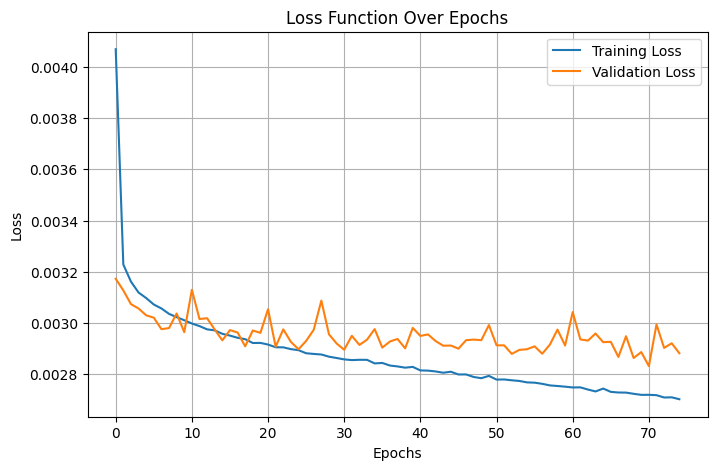

In [133]:
plot_loss(history_lab_bn)

In [165]:
import json
# Sauvegarder l'historique dans un fichier JSON
with open('history_lab.json', 'w') as f:
    json.dump(history_lab.history, f)

In [166]:
import json
# Sauvegarder l'historique dans un fichier JSON
with open('history_lab_bn.json', 'w') as f:
    json.dump(history_lab_bn.history, f)

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Function to convert Lab to RGB for visualization
def convert_lab_to_rgb(l_channel, ab_channels):
    """
    Converts L and ab channels into RGB format using skimage's lab2rgb.
    """
    l_channel = (l_channel ) * 100.0  # Scale back to Lab range
    ab_channels = (ab_channels ) * 256.0 - 128 # Scale back to Lab range
    lab = tf.concat([l_channel,ab_channels], axis=-1)
    rgb = tensorflow_io.python.experimental.color_ops.lab_to_rgb(lab)

    return rgb

# Function to predict and visualize colorized images
def predict_and_visualize(model, dataset, num_images=5):
    """
    Predicts and visualizes images from the dataset.
    Args:
        model: Trained colorization model
        dataset: Dataset with grayscale (L channel) inputs
        num_images: Number of images to visualize
    """
    losses = []
    # Take a batch of images
    for batch, ground_truth, l in dataset.take(1):
        # Only take 1 batch for visualization
        # print(batch)
        l_inputs = batch
        l_inputs = l_inputs[:num_images]  # Limit the number of images
        ground_truth = ground_truth[:num_images]

        # Predict ab channels
        predicted_ab = model.predict(l_inputs)
        # predicted_ab = np.array(predicted_ab)
        # Prepare for visualization
        for i in range(num_images):
            l_channel = l_inputs[i]
            
            ab_channels_pred = np.array(predicted_ab[i])

            print(ab_channels_pred.shape)
            # ab_channels_pred = tf.reverse(ab_channels_pred, axis=[-1])

            ab_channels_gt = ground_truth[i]
            # print(tf.reduce_min(ab_channels_gt), tf.reduce_max(ab_channels_gt))
            # print(ground_truth[i].shape, predicted_ab[i].shape, ab_channels_gt.shape, ab_channels_pred.shape)

            # Convert to RGB for visualization
            pred_rgb = convert_lab_to_rgb(l_channel, ab_channels_pred)
            gt_rgb = convert_lab_to_rgb(l_channel, ab_channels_gt)

            # Plot images
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 7, 1)
            plt.imshow(l_channel, cmap="gray")
            plt.title("Grayscale (L Channel)")
            plt.axis("off")

            plt.subplot(1, 7, 2)
            plt.imshow(ab_channels_pred[..., 1], cmap = "gray")
            # plt.imshow(pred_rgb)
            plt.title("Predicted b")
            plt.axis("off")

            plt.subplot(1, 7, 3)
            plt.imshow(ab_channels_gt[..., 1], cmap = "gray")
            # plt.imshow(gt_rgb)
            plt.title("Ground Truth b")
            plt.axis("off")

            plt.subplot(1, 7, 4)
            plt.imshow(ab_channels_pred[..., 0], cmap = "gray")
            # plt.imshow(pred_rgb)
            plt.title("Predicted a")
            plt.axis("off")

            plt.subplot(1, 7, 5)
            plt.imshow(ab_channels_gt[..., 0], cmap = "gray")
            # plt.imshow(gt_rgb)
            plt.title("Ground Truth a")
            plt.axis("off")
            plt.subplot(1, 7, 6)
            # plt.imshow(ab_channels_pred[..., 0], cmap = "gray")
            plt.imshow(pred_rgb)
            plt.title("Predicted rgb")
            plt.axis("off")

            plt.subplot(1, 7, 7)
            # plt.imshow(ab_channels_gt[..., 0], cmap = "gray")
            # print(gt_rgb)
            plt.imshow(gt_rgb)
            plt.title("Ground Truth rgb")
            plt.axis("off")

            plt.show()
            # losses.append(tf.reduce_mean(tf.square( ab_channels_gt, ab_channels_pred)))
            losses.append(tf.reduce_mean(tf.square( pred_rgb, gt_rgb)))
            mse = tf.keras.losses.MeanSquaredError()
            print( mse( ab_channels_gt[..., 1], ab_channels_pred[..., 1]))
            # print(mse( ab_channels_gt, ab_channels_pred))
            print( mse( ab_channels_gt[..., 0], ab_channels_pred[..., 0]))

            # print(tf.reduce_mean(tf.square( ab_channels_gt, ab_channels_pred)) )

        return losses




# Lab model with vgg16 added

In [15]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Flatten, Dense, RepeatVector, Reshape, Lambda
from tensorflow.keras.applications import VGG16



def create_lab_colorization_model_with_vgg_features():
    # input_l = Input(shape=(input_shape[0], input_shape[1], 1), name="Input_L")
    # input_l_rgb = Lambda(lambda x: tf.image.grayscale_to_rgb(x), name="Pseudo_RGB")(input_l)
    input_l = Input(shape=(input_shape[0], input_shape[1], 1), name="Input_L")
    input_l_rgb = Lambda(
        lambda x: tf.image.grayscale_to_rgb(x),
        output_shape=(input_shape[0], input_shape[1], 3),
        name="Pseudo_RGB"
    )(input_l)
    # Extract features from VGG16
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))
    vgg_extractor = Model(vgg_model.input, vgg_model.layers[-6].output)  
    vgg_features = vgg_extractor(input_l_rgb)  

    # Process global features with additional layers
    global_features = Conv2D(512, (3, 3), padding='same', strides=(2, 2), activation='relu')(vgg_features)
    global_features = BatchNormalization()(global_features)
    global_features = Conv2D(512, (3, 3), padding='same', strides=(1, 1), activation='relu')(global_features)
    global_features = BatchNormalization()(global_features)
    global_features = UpSampling2D((2, 2))(global_features)

    # Encoder (downsampling) with skip connections
    x1 = Conv2D(64, (3, 3), activation="relu", padding="same", strides=1)(input_l)
    x1 = BatchNormalization()(x1)
    x2 = Conv2D(128, (3, 3), activation="relu", padding="same", strides=2)(x1)  
    x2 = BatchNormalization()(x2)
    x3 = Conv2D(256, (3, 3), activation="relu", padding="same", strides=2)(x2)  
    x3 = BatchNormalization()(x3)
    x4 = Conv2D(512, (3, 3), activation="relu", padding="same", strides=2)(x3)  
    x4 = BatchNormalization()(x4)

    # Merge global features into the decoder
    x4 = Concatenate()([x4, global_features])
    x4 = BatchNormalization()(x4)

    # Decoder (upsampling) with skip connections
    x5 = UpSampling2D((2, 2))(x4)  # Upsampling
    x5 = Concatenate()([x5, x3])  # Skip connection
    x5 = Conv2D(256, (3, 3), activation="relu", padding="same")(x5)
    x5 = BatchNormalization()(x5)

    x6 = UpSampling2D((2, 2))(x5)  # Upsampling
    x6 = Concatenate()([x6, x2])  # Skip connection
    x6 = Conv2D(128, (3, 3), activation="relu", padding="same")(x6)
    x6 = BatchNormalization()(x6)

    x7 = UpSampling2D((2, 2))(x6)  # Upsampling
    x7 = Concatenate()([x7, x1])  # Skip connection
    x7 = Conv2D(64, (3, 3), activation="relu", padding="same")(x7)
    x7 = BatchNormalization()(x7)

    # Final output layer for ab channels
    ab_output = Conv2D(2, (1, 1), activation="sigmoid", name="Output_ab")(x7)

    # Combine inputs and outputs into the final model
    model = Model(inputs=input_l, outputs=[ab_output], name="Lab_Colorization_Model_With_VGG_Features")

    return model





In [ ]:
# model_lab_vgg.save("colorization_lab_model_224x224_75epochs_kip_connections_and_vgg16.keras")

In [16]:
# Define input shape for grayscale (L channel)
input_shape = (image_size[0], image_size[1], 1)

# Instantiate the model
model_lab_vgg = create_lab_colorization_model_with_vgg_features()
model_lab_vgg.summary()

losses = {
    "Output_ab": "mse", 
}

loss_weights = {
    "Output_ab": 1.0,
}

# Compile the model
model_lab_vgg.compile(
    optimizer= Adam(learning_rate=0.00002),
    loss=losses,
    loss_weights=loss_weights,
    metrics=['mae', 'mse', ssim, psnr]
)


Model: "Lab_Colorization_Model_With_VGG_Features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_L             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        640 │ Input_L[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pseudo_RGB (Lambda) │ (None, 256, 256,  │          0 │ Input_L[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 32, 32,    │  7,635,264 │ Pseudo_RGB[0][0]  │
│ (Functional)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │  2,359,808 │ functional_1[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │      2,048 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 17,421,186 (66.46 MB)

 Trainable params: 17,414,274 (66.43 MB)

 Non-trainable params: 6,912 (27.00 KB)

In [19]:
train_model(model_lab_vgg, "lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark", "lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark_loss", benchmark_epochs)

# history_vgg = model_lab_vgg.fit(
#     train_dataset,  
#     validation_data=val_dataset,
#     epochs=100,
#     # callbacks = [save_callback_lab , early_stop]
# )

Epoch 1/75


2024-12-17 12:15:15.551488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 522 of 1000
2024-12-17 12:15:20.145188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1734434120.152685  259909 service.cc:146] XLA service 0x7ab4c8003cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734434120.152711  259909 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-17 12:15:20.331489: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1734434120.505034  259909 assert_op.cc:38] Ignoring Assert operator Lab_Colorization_Model_With_VGG_Features_1/Pseudo_RGB_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1734434120.505108  259909 assert_op.cc:38] 

1996/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0041 - mae: 0.0671 - mse: 0.0098 - psnr: 22.3145 - ssim: 0.5403

W0000 00:00:1734434459.189745  259909 assert_op.cc:38] Ignoring Assert operator Lab_Colorization_Model_With_VGG_Features_1/Pseudo_RGB_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1734434459.189840  259909 assert_op.cc:38] Ignoring Assert operator Lab_Colorization_Model_With_VGG_Features_1/Pseudo_RGB_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
W0000 00:00:1734434459.292618  259909 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1734434459.293102  259909 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1734434459.293626  259909 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1734434459.293957  259909 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
W0000 00:00:1734434459.294024  259909 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1734434459.294078  259909 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert



Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 388s 171ms/step - loss: 0.0041 - mae: 0.0671 - mse: 0.0098 - psnr: 22.3161 - ssim: 0.5404 - val_loss: 0.0016 - val_mae: 0.0402 - val_mse: 0.0032 - val_psnr: 26.0977 - val_ssim: 0.7765
Epoch 2/75


2024-12-17 12:21:38.331869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 483 of 1000
2024-12-17 12:21:43.699033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0016 - mae: 0.0401 - mse: 0.0033 - psnr: 26.0937 - ssim: 0.7846
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 162ms/step - loss: 0.0016 - mae: 0.0401 - mse: 0.0033 - psnr: 26.0937 - ssim: 0.7846 - val_loss: 0.0015 - val_mae: 0.0370 - val_mse: 0.0029 - val_psnr: 26.6606 - val_ssim: 0.8116
Epoch 3/75


2024-12-17 12:27:18.904619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 485 of 1000
2024-12-17 12:27:24.269180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0016 - mae: 0.0390 - mse: 0.0032 - psnr: 26.3230 - ssim: 0.8118
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 0.0016 - mae: 0.0390 - mse: 0.0032 - psnr: 26.3231 - ssim: 0.8118 - val_loss: 0.0014 - val_mae: 0.0372 - val_mse: 0.0029 - val_psnr: 26.6950 - val_ssim: 0.8267
Epoch 4/75


2024-12-17 12:32:58.967419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 463 of 1000
2024-12-17 12:33:04.818290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1996/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0015 - mae: 0.0382 - mse: 0.0030 - psnr: 26.4771 - ssim: 0.8251
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 162ms/step - loss: 0.0015 - mae: 0.0382 - mse: 0.0030 - psnr: 26.4771 - ssim: 0.8251 - val_loss: 0.0014 - val_mae: 0.0366 - val_mse: 0.0029 - val_psnr: 26.7495 - val_ssim: 0.8341
Epoch 5/75


2024-12-17 12:38:39.918882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 486 of 1000
2024-12-17 12:38:45.210105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0015 - mae: 0.0375 - mse: 0.0029 - psnr: 26.6424 - ssim: 0.8315
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 0.0015 - mae: 0.0375 - mse: 0.0029 - psnr: 26.6425 - ssim: 0.8315 - val_loss: 0.0014 - val_mae: 0.0372 - val_mse: 0.0028 - val_psnr: 26.7044 - val_ssim: 0.8362
Epoch 6/75


2024-12-17 12:44:20.296714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 448 of 1000
2024-12-17 12:44:26.200508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0014 - mae: 0.0374 - mse: 0.0029 - psnr: 26.6397 - ssim: 0.8322
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 0.0014 - mae: 0.0374 - mse: 0.0029 - psnr: 26.6397 - ssim: 0.8322 - val_loss: 0.0014 - val_mae: 0.0351 - val_mse: 0.0027 - val_psnr: 27.1681 - val_ssim: 0.8390
Epoch 7/75


2024-12-17 12:50:01.614267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 490 of 1000
2024-12-17 12:50:06.900033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0014 - mae: 0.0365 - mse: 0.0028 - psnr: 26.8465 - ssim: 0.8374
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 0.0014 - mae: 0.0365 - mse: 0.0028 - psnr: 26.8465 - ssim: 0.8374 - val_loss: 0.0014 - val_mae: 0.0361 - val_mse: 0.0028 - val_psnr: 26.9973 - val_ssim: 0.8399
Epoch 8/75


2024-12-17 12:55:41.879047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 469 of 1000
2024-12-17 12:55:47.437907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0013 - mae: 0.0363 - mse: 0.0027 - psnr: 26.8589 - ssim: 0.8395
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 0.0013 - mae: 0.0363 - mse: 0.0027 - psnr: 26.8589 - ssim: 0.8395 - val_loss: 0.0014 - val_mae: 0.0364 - val_mse: 0.0028 - val_psnr: 26.7476 - val_ssim: 0.8397
Epoch 9/75


2024-12-17 13:01:22.878484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 480 of 1000
2024-12-17 13:01:28.453947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0013 - mae: 0.0361 - mse: 0.0027 - psnr: 26.8990 - ssim: 0.8389
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 0.0013 - mae: 0.0361 - mse: 0.0027 - psnr: 26.8990 - ssim: 0.8389 - val_loss: 0.0014 - val_mae: 0.0355 - val_mse: 0.0027 - val_psnr: 27.0453 - val_ssim: 0.8415
Epoch 10/75


2024-12-17 13:07:03.008918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 465 of 1000
2024-12-17 13:07:08.754103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0012 - mae: 0.0359 - mse: 0.0026 - psnr: 26.9094 - ssim: 0.8395
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 0.0012 - mae: 0.0359 - mse: 0.0026 - psnr: 26.9094 - ssim: 0.8395 - val_loss: 0.0014 - val_mae: 0.0344 - val_mse: 0.0027 - val_psnr: 27.2515 - val_ssim: 0.8428
Epoch 11/75


2024-12-17 13:12:43.257661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 480 of 1000
2024-12-17 13:12:48.768303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0012 - mae: 0.0351 - mse: 0.0025 - psnr: 27.0819 - ssim: 0.8392
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 0.0012 - mae: 0.0351 - mse: 0.0025 - psnr: 27.0819 - ssim: 0.8392 - val_loss: 0.0014 - val_mae: 0.0361 - val_mse: 0.0028 - val_psnr: 26.7021 - val_ssim: 0.8412
Epoch 12/75


2024-12-17 13:18:23.453060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 484 of 1000
2024-12-17 13:18:28.827011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0011 - mae: 0.0346 - mse: 0.0025 - psnr: 27.1603 - ssim: 0.8399
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 0.0011 - mae: 0.0346 - mse: 0.0025 - psnr: 27.1603 - ssim: 0.8399 - val_loss: 0.0014 - val_mae: 0.0354 - val_mse: 0.0028 - val_psnr: 26.9582 - val_ssim: 0.8412
Epoch 13/75


2024-12-17 13:24:03.405854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 476 of 1000
2024-12-17 13:24:08.975967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0010 - mae: 0.0341 - mse: 0.0024 - psnr: 27.2529 - ssim: 0.8403
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 0.0010 - mae: 0.0341 - mse: 0.0024 - psnr: 27.2529 - ssim: 0.8403 - val_loss: 0.0014 - val_mae: 0.0353 - val_mse: 0.0028 - val_psnr: 26.9533 - val_ssim: 0.8410
Epoch 14/75


2024-12-17 13:29:43.899290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 466 of 1000
2024-12-17 13:29:49.628084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 9.6392e-04 - mae: 0.0336 - mse: 0.0023 - psnr: 27.3575 - ssim: 0.8405
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 9.6392e-04 - mae: 0.0336 - mse: 0.0023 - psnr: 27.3575 - ssim: 0.8405 - val_loss: 0.0014 - val_mae: 0.0352 - val_mse: 0.0028 - val_psnr: 26.9661 - val_ssim: 0.8410
Epoch 15/75


2024-12-17 13:35:24.259753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 481 of 1000
2024-12-17 13:35:29.927268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 9.1553e-04 - mae: 0.0332 - mse: 0.0023 - psnr: 27.4585 - ssim: 0.8398
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 9.1553e-04 - mae: 0.0332 - mse: 0.0023 - psnr: 27.4585 - ssim: 0.8398 - val_loss: 0.0014 - val_mae: 0.0362 - val_mse: 0.0029 - val_psnr: 26.7274 - val_ssim: 0.8389
Epoch 16/75


2024-12-17 13:41:04.434322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 478 of 1000
2024-12-17 13:41:09.903998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 8.6065e-04 - mae: 0.0325 - mse: 0.0022 - psnr: 27.5841 - ssim: 0.8395
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 8.6065e-04 - mae: 0.0325 - mse: 0.0022 - psnr: 27.5840 - ssim: 0.8395 - val_loss: 0.0015 - val_mae: 0.0373 - val_mse: 0.0030 - val_psnr: 26.4850 - val_ssim: 0.8366
Epoch 17/75


2024-12-17 13:46:45.184033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 497 of 1000
2024-12-17 13:46:50.416272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 8.1913e-04 - mae: 0.0321 - mse: 0.0022 - psnr: 27.6806 - ssim: 0.8410
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 8.1914e-04 - mae: 0.0321 - mse: 0.0022 - psnr: 27.6806 - ssim: 0.8410 - val_loss: 0.0015 - val_mae: 0.0369 - val_mse: 0.0029 - val_psnr: 26.5330 - val_ssim: 0.8370
Epoch 18/75


2024-12-17 13:52:25.359543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 488 of 1000
2024-12-17 13:52:30.781559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 7.7992e-04 - mae: 0.0317 - mse: 0.0021 - psnr: 27.7315 - ssim: 0.8409
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 7.7992e-04 - mae: 0.0317 - mse: 0.0021 - psnr: 27.7315 - ssim: 0.8409 - val_loss: 0.0015 - val_mae: 0.0369 - val_mse: 0.0029 - val_psnr: 26.5178 - val_ssim: 0.8360
Epoch 19/75


2024-12-17 13:58:05.751560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 488 of 1000
2024-12-17 13:58:11.267892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 7.5972e-04 - mae: 0.0316 - mse: 0.0021 - psnr: 27.7852 - ssim: 0.8406
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 7.5972e-04 - mae: 0.0316 - mse: 0.0021 - psnr: 27.7852 - ssim: 0.8406 - val_loss: 0.0015 - val_mae: 0.0365 - val_mse: 0.0029 - val_psnr: 26.6032 - val_ssim: 0.8366
Epoch 20/75


2024-12-17 14:03:45.859207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 458 of 1000
2024-12-17 14:03:51.467313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 7.1717e-04 - mae: 0.0309 - mse: 0.0021 - psnr: 27.9066 - ssim: 0.8402
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 162ms/step - loss: 7.1717e-04 - mae: 0.0309 - mse: 0.0021 - psnr: 27.9066 - ssim: 0.8402 - val_loss: 0.0015 - val_mae: 0.0373 - val_mse: 0.0030 - val_psnr: 26.4031 - val_ssim: 0.8346
Epoch 21/75


2024-12-17 14:09:26.059971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 484 of 1000
2024-12-17 14:09:31.619360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 6.9571e-04 - mae: 0.0309 - mse: 0.0021 - psnr: 27.8787 - ssim: 0.8401
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 6.9571e-04 - mae: 0.0309 - mse: 0.0021 - psnr: 27.8787 - ssim: 0.8401 - val_loss: 0.0015 - val_mae: 0.0373 - val_mse: 0.0030 - val_psnr: 26.4872 - val_ssim: 0.8367
Epoch 22/75


2024-12-17 14:15:07.012833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 452 of 1000
2024-12-17 14:15:12.842181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 6.6233e-04 - mae: 0.0304 - mse: 0.0020 - psnr: 27.9980 - ssim: 0.8400
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 6.6233e-04 - mae: 0.0304 - mse: 0.0020 - psnr: 27.9980 - ssim: 0.8400 - val_loss: 0.0015 - val_mae: 0.0370 - val_mse: 0.0030 - val_psnr: 26.4541 - val_ssim: 0.8363
Epoch 23/75


2024-12-17 14:20:48.233006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 480 of 1000
2024-12-17 14:20:53.913035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 6.3817e-04 - mae: 0.0301 - mse: 0.0021 - psnr: 28.0280 - ssim: 0.8400
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 162ms/step - loss: 6.3817e-04 - mae: 0.0301 - mse: 0.0021 - psnr: 28.0279 - ssim: 0.8400 - val_loss: 0.0015 - val_mae: 0.0374 - val_mse: 0.0030 - val_psnr: 26.3968 - val_ssim: 0.8352
Epoch 24/75


2024-12-17 14:26:29.010105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 451 of 1000
2024-12-17 14:26:34.832978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 6.1692e-04 - mae: 0.0298 - mse: 0.0021 - psnr: 28.0756 - ssim: 0.8402
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 6.1692e-04 - mae: 0.0298 - mse: 0.0021 - psnr: 28.0755 - ssim: 0.8402 - val_loss: 0.0014 - val_mae: 0.0365 - val_mse: 0.0029 - val_psnr: 26.5774 - val_ssim: 0.8367
Epoch 25/75


2024-12-17 14:32:10.303400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 466 of 1000
2024-12-17 14:32:16.142130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 6.0003e-04 - mae: 0.0296 - mse: 0.0020 - psnr: 28.1349 - ssim: 0.8396
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 6.0003e-04 - mae: 0.0296 - mse: 0.0020 - psnr: 28.1349 - ssim: 0.8396 - val_loss: 0.0014 - val_mae: 0.0364 - val_mse: 0.0029 - val_psnr: 26.6339 - val_ssim: 0.8375
Epoch 26/75


2024-12-17 14:37:51.954614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 469 of 1000
2024-12-17 14:37:57.753933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 5.7107e-04 - mae: 0.0290 - mse: 0.0020 - psnr: 28.2931 - ssim: 0.8413
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 5.7107e-04 - mae: 0.0290 - mse: 0.0020 - psnr: 28.2930 - ssim: 0.8413 - val_loss: 0.0014 - val_mae: 0.0369 - val_mse: 0.0030 - val_psnr: 26.5676 - val_ssim: 0.8353
Epoch 27/75


2024-12-17 14:43:33.083290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 485 of 1000
2024-12-17 14:43:38.846575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 5.5766e-04 - mae: 0.0288 - mse: 0.0020 - psnr: 28.2820 - ssim: 0.8433
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 5.5766e-04 - mae: 0.0288 - mse: 0.0020 - psnr: 28.2820 - ssim: 0.8433 - val_loss: 0.0014 - val_mae: 0.0370 - val_mse: 0.0030 - val_psnr: 26.4574 - val_ssim: 0.8361
Epoch 28/75


2024-12-17 14:49:14.591709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 459 of 1000
2024-12-17 14:49:20.178779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 5.4108e-04 - mae: 0.0286 - mse: 0.0020 - psnr: 28.3116 - ssim: 0.8429
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 162ms/step - loss: 5.4109e-04 - mae: 0.0286 - mse: 0.0020 - psnr: 28.3116 - ssim: 0.8429 - val_loss: 0.0014 - val_mae: 0.0365 - val_mse: 0.0029 - val_psnr: 26.5975 - val_ssim: 0.8369
Epoch 29/75


2024-12-17 14:54:55.253265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 465 of 1000
2024-12-17 14:55:01.198945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 5.3234e-04 - mae: 0.0285 - mse: 0.0021 - psnr: 28.2851 - ssim: 0.8407
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 5.3233e-04 - mae: 0.0285 - mse: 0.0021 - psnr: 28.2851 - ssim: 0.8407 - val_loss: 0.0014 - val_mae: 0.0364 - val_mse: 0.0029 - val_psnr: 26.5983 - val_ssim: 0.8357
Epoch 30/75


2024-12-17 15:00:36.882803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 466 of 1000
2024-12-17 15:00:42.940667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 5.1352e-04 - mae: 0.0284 - mse: 0.0021 - psnr: 28.3277 - ssim: 0.8409
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 5.1352e-04 - mae: 0.0284 - mse: 0.0021 - psnr: 28.3277 - ssim: 0.8409 - val_loss: 0.0015 - val_mae: 0.0378 - val_mse: 0.0031 - val_psnr: 26.2867 - val_ssim: 0.8331
Epoch 31/75


2024-12-17 15:06:18.493448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 460 of 1000
2024-12-17 15:06:24.625843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 5.0706e-04 - mae: 0.0283 - mse: 0.0021 - psnr: 28.2586 - ssim: 0.8408
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 5.0706e-04 - mae: 0.0283 - mse: 0.0021 - psnr: 28.2586 - ssim: 0.8408 - val_loss: 0.0015 - val_mae: 0.0379 - val_mse: 0.0031 - val_psnr: 26.2968 - val_ssim: 0.8335
Epoch 32/75


2024-12-17 15:12:00.118002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 478 of 1000
2024-12-17 15:12:05.929217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.8985e-04 - mae: 0.0278 - mse: 0.0021 - psnr: 28.3595 - ssim: 0.8412
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 4.8985e-04 - mae: 0.0278 - mse: 0.0021 - psnr: 28.3595 - ssim: 0.8412 - val_loss: 0.0014 - val_mae: 0.0368 - val_mse: 0.0030 - val_psnr: 26.5038 - val_ssim: 0.8347
Epoch 33/75


2024-12-17 15:17:41.943315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 460 of 1000
2024-12-17 15:17:47.705827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.8095e-04 - mae: 0.0276 - mse: 0.0021 - psnr: 28.4247 - ssim: 0.8419
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 4.8095e-04 - mae: 0.0276 - mse: 0.0021 - psnr: 28.4247 - ssim: 0.8419 - val_loss: 0.0014 - val_mae: 0.0368 - val_mse: 0.0030 - val_psnr: 26.5129 - val_ssim: 0.8344
Epoch 34/75


2024-12-17 15:23:23.264323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 473 of 1000
2024-12-17 15:23:29.283415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.7176e-04 - mae: 0.0276 - mse: 0.0021 - psnr: 28.4104 - ssim: 0.8419
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 4.7176e-04 - mae: 0.0276 - mse: 0.0021 - psnr: 28.4104 - ssim: 0.8419 - val_loss: 0.0014 - val_mae: 0.0370 - val_mse: 0.0030 - val_psnr: 26.4824 - val_ssim: 0.8359
Epoch 35/75


2024-12-17 15:29:05.420102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 472 of 1000
2024-12-17 15:29:11.462267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.6240e-04 - mae: 0.0275 - mse: 0.0021 - psnr: 28.3695 - ssim: 0.8412
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 4.6240e-04 - mae: 0.0275 - mse: 0.0021 - psnr: 28.3695 - ssim: 0.8412 - val_loss: 0.0014 - val_mae: 0.0366 - val_mse: 0.0030 - val_psnr: 26.5575 - val_ssim: 0.8362
Epoch 36/75


2024-12-17 15:34:46.655688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 452 of 1000
2024-12-17 15:34:52.681701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.5024e-04 - mae: 0.0271 - mse: 0.0021 - psnr: 28.4909 - ssim: 0.8421
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 4.5024e-04 - mae: 0.0271 - mse: 0.0021 - psnr: 28.4908 - ssim: 0.8421 - val_loss: 0.0014 - val_mae: 0.0368 - val_mse: 0.0030 - val_psnr: 26.5503 - val_ssim: 0.8354
Epoch 37/75


2024-12-17 15:40:28.640572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 483 of 1000
2024-12-17 15:40:34.094227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.3711e-04 - mae: 0.0269 - mse: 0.0021 - psnr: 28.5019 - ssim: 0.8424
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 4.3711e-04 - mae: 0.0269 - mse: 0.0021 - psnr: 28.5019 - ssim: 0.8424 - val_loss: 0.0014 - val_mae: 0.0369 - val_mse: 0.0030 - val_psnr: 26.4532 - val_ssim: 0.8353
Epoch 38/75


2024-12-17 15:46:09.749601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 454 of 1000
2024-12-17 15:46:16.164671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.3824e-04 - mae: 0.0268 - mse: 0.0021 - psnr: 28.5042 - ssim: 0.8421
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 162ms/step - loss: 4.3823e-04 - mae: 0.0268 - mse: 0.0021 - psnr: 28.5042 - ssim: 0.8421 - val_loss: 0.0015 - val_mae: 0.0374 - val_mse: 0.0031 - val_psnr: 26.3282 - val_ssim: 0.8335
Epoch 39/75


2024-12-17 15:51:51.309424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 466 of 1000
2024-12-17 15:51:57.142419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.2634e-04 - mae: 0.0266 - mse: 0.0021 - psnr: 28.5021 - ssim: 0.8448
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 4.2634e-04 - mae: 0.0266 - mse: 0.0021 - psnr: 28.5021 - ssim: 0.8448 - val_loss: 0.0014 - val_mae: 0.0367 - val_mse: 0.0030 - val_psnr: 26.5370 - val_ssim: 0.8352
Epoch 40/75


2024-12-17 15:57:32.485388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 486 of 1000
2024-12-17 15:57:37.958520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.2163e-04 - mae: 0.0264 - mse: 0.0021 - psnr: 28.5480 - ssim: 0.8434
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 4.2163e-04 - mae: 0.0264 - mse: 0.0021 - psnr: 28.5479 - ssim: 0.8434 - val_loss: 0.0014 - val_mae: 0.0378 - val_mse: 0.0031 - val_psnr: 26.2995 - val_ssim: 0.8331
Epoch 41/75


2024-12-17 16:03:13.560799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 441 of 1000
2024-12-17 16:03:19.662525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.0937e-04 - mae: 0.0260 - mse: 0.0022 - psnr: 28.5881 - ssim: 0.8447
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 4.0937e-04 - mae: 0.0260 - mse: 0.0022 - psnr: 28.5881 - ssim: 0.8447 - val_loss: 0.0014 - val_mae: 0.0377 - val_mse: 0.0031 - val_psnr: 26.2577 - val_ssim: 0.8340
Epoch 42/75


2024-12-17 16:08:55.639226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 458 of 1000
2024-12-17 16:09:01.469503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.1029e-04 - mae: 0.0261 - mse: 0.0022 - psnr: 28.5413 - ssim: 0.8438
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 162ms/step - loss: 4.1029e-04 - mae: 0.0261 - mse: 0.0022 - psnr: 28.5413 - ssim: 0.8438 - val_loss: 0.0014 - val_mae: 0.0369 - val_mse: 0.0030 - val_psnr: 26.4807 - val_ssim: 0.8344
Epoch 43/75


2024-12-17 16:14:36.373350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 470 of 1000
2024-12-17 16:14:42.093810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.0079e-04 - mae: 0.0259 - mse: 0.0022 - psnr: 28.5887 - ssim: 0.8449
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 4.0079e-04 - mae: 0.0259 - mse: 0.0022 - psnr: 28.5887 - ssim: 0.8449 - val_loss: 0.0014 - val_mae: 0.0380 - val_mse: 0.0031 - val_psnr: 26.2187 - val_ssim: 0.8326
Epoch 44/75


2024-12-17 16:20:18.138205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 485 of 1000
2024-12-17 16:20:24.350186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.8515e-04 - mae: 0.0257 - mse: 0.0022 - psnr: 28.6570 - ssim: 0.8455
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.8515e-04 - mae: 0.0257 - mse: 0.0022 - psnr: 28.6570 - ssim: 0.8455 - val_loss: 0.0014 - val_mae: 0.0371 - val_mse: 0.0031 - val_psnr: 26.4293 - val_ssim: 0.8341
Epoch 45/75


2024-12-17 16:26:00.102105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 466 of 1000
2024-12-17 16:26:06.393146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.9212e-04 - mae: 0.0259 - mse: 0.0022 - psnr: 28.5368 - ssim: 0.8435
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.9212e-04 - mae: 0.0259 - mse: 0.0022 - psnr: 28.5368 - ssim: 0.8435 - val_loss: 0.0014 - val_mae: 0.0375 - val_mse: 0.0031 - val_psnr: 26.3483 - val_ssim: 0.8327
Epoch 46/75


2024-12-17 16:31:42.477434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 466 of 1000
2024-12-17 16:31:48.524929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.6688e-04 - mae: 0.0250 - mse: 0.0021 - psnr: 28.7976 - ssim: 0.8464
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.6688e-04 - mae: 0.0250 - mse: 0.0021 - psnr: 28.7975 - ssim: 0.8464 - val_loss: 0.0014 - val_mae: 0.0379 - val_mse: 0.0032 - val_psnr: 26.2365 - val_ssim: 0.8319
Epoch 47/75


2024-12-17 16:37:24.331573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 434 of 1000
2024-12-17 16:37:30.380104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.7063e-04 - mae: 0.0253 - mse: 0.0022 - psnr: 28.6387 - ssim: 0.8453
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.7063e-04 - mae: 0.0253 - mse: 0.0022 - psnr: 28.6386 - ssim: 0.8453 - val_loss: 0.0014 - val_mae: 0.0377 - val_mse: 0.0034 - val_psnr: 26.1880 - val_ssim: 0.8327
Epoch 48/75


2024-12-17 16:43:06.032152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 465 of 1000
2024-12-17 16:43:12.076575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.5960e-04 - mae: 0.0246 - mse: 0.0021 - psnr: 28.8464 - ssim: 0.8464
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.5960e-04 - mae: 0.0246 - mse: 0.0021 - psnr: 28.8463 - ssim: 0.8464 - val_loss: 0.0014 - val_mae: 0.0378 - val_mse: 0.0034 - val_psnr: 26.2190 - val_ssim: 0.8314
Epoch 49/75


2024-12-17 16:48:47.830106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 467 of 1000
2024-12-17 16:48:54.248293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.5913e-04 - mae: 0.0249 - mse: 0.0022 - psnr: 28.7815 - ssim: 0.8467
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.5913e-04 - mae: 0.0249 - mse: 0.0022 - psnr: 28.7815 - ssim: 0.8467 - val_loss: 0.0014 - val_mae: 0.0375 - val_mse: 0.0032 - val_psnr: 26.3040 - val_ssim: 0.8303
Epoch 50/75


2024-12-17 16:54:29.995181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 441 of 1000
2024-12-17 16:54:36.208420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.6255e-04 - mae: 0.0247 - mse: 0.0022 - psnr: 28.7582 - ssim: 0.8485
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.6255e-04 - mae: 0.0247 - mse: 0.0022 - psnr: 28.7583 - ssim: 0.8485 - val_loss: 0.0014 - val_mae: 0.0391 - val_mse: 0.0034 - val_psnr: 25.9925 - val_ssim: 0.8304
Epoch 51/75


2024-12-17 17:00:11.596998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 443 of 1000
2024-12-17 17:00:17.677779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.5476e-04 - mae: 0.0247 - mse: 0.0022 - psnr: 28.7315 - ssim: 0.8472
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.5476e-04 - mae: 0.0247 - mse: 0.0022 - psnr: 28.7315 - ssim: 0.8472 - val_loss: 0.0014 - val_mae: 0.0375 - val_mse: 0.0032 - val_psnr: 26.3069 - val_ssim: 0.8338
Epoch 52/75


2024-12-17 17:05:53.793750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 476 of 1000
2024-12-17 17:05:59.835469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1996/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 3.5178e-04 - mae: 0.0245 - mse: 0.0022 - psnr: 28.8133 - ssim: 0.8482
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.5178e-04 - mae: 0.0245 - mse: 0.0022 - psnr: 28.8133 - ssim: 0.8482 - val_loss: 0.0014 - val_mae: 0.0380 - val_mse: 0.0036 - val_psnr: 26.1587 - val_ssim: 0.8324
Epoch 53/75


2024-12-17 17:11:36.066362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 415 of 1000
2024-12-17 17:11:42.512448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.4540e-04 - mae: 0.0243 - mse: 0.0022 - psnr: 28.8264 - ssim: 0.8480
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.4538e-04 - mae: 0.0243 - mse: 0.0022 - psnr: 28.8264 - ssim: 0.8480 - val_loss: 0.0014 - val_mae: 0.0383 - val_mse: 0.0035 - val_psnr: 26.0907 - val_ssim: 0.8309
Epoch 54/75


2024-12-17 17:17:18.207400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 457 of 1000
2024-12-17 17:17:24.064599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.4298e-04 - mae: 0.0243 - mse: 0.0022 - psnr: 28.8230 - ssim: 0.8483
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 3.4298e-04 - mae: 0.0243 - mse: 0.0022 - psnr: 28.8230 - ssim: 0.8483 - val_loss: 0.0014 - val_mae: 0.0387 - val_mse: 0.0037 - val_psnr: 26.0218 - val_ssim: 0.8319
Epoch 55/75


2024-12-17 17:22:59.468878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 485 of 1000
2024-12-17 17:23:04.999680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.2952e-04 - mae: 0.0238 - mse: 0.0021 - psnr: 28.9811 - ssim: 0.8502
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 3.2952e-04 - mae: 0.0238 - mse: 0.0021 - psnr: 28.9811 - ssim: 0.8502 - val_loss: 0.0014 - val_mae: 0.0381 - val_mse: 0.0034 - val_psnr: 26.1707 - val_ssim: 0.8325
Epoch 56/75


2024-12-17 17:28:40.373488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 470 of 1000
2024-12-17 17:28:46.394962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.3059e-04 - mae: 0.0238 - mse: 0.0021 - psnr: 29.0003 - ssim: 0.8502
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.3059e-04 - mae: 0.0238 - mse: 0.0021 - psnr: 29.0002 - ssim: 0.8502 - val_loss: 0.0014 - val_mae: 0.0379 - val_mse: 0.0033 - val_psnr: 26.2710 - val_ssim: 0.8306
Epoch 57/75


2024-12-17 17:34:22.273376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 476 of 1000
2024-12-17 17:34:27.841772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.2588e-04 - mae: 0.0235 - mse: 0.0021 - psnr: 29.0371 - ssim: 0.8499
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - loss: 3.2588e-04 - mae: 0.0235 - mse: 0.0021 - psnr: 29.0371 - ssim: 0.8499 - val_loss: 0.0014 - val_mae: 0.0368 - val_mse: 0.0032 - val_psnr: 26.4635 - val_ssim: 0.8338
Epoch 58/75


2024-12-17 17:40:04.636380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 442 of 1000
2024-12-17 17:40:10.743315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 3.1750e-04 - mae: 0.0233 - mse: 0.0021 - psnr: 29.0783 - ssim: 0.8514
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 3.1750e-04 - mae: 0.0233 - mse: 0.0021 - psnr: 29.0783 - ssim: 0.8514 - val_loss: 0.0014 - val_mae: 0.0383 - val_mse: 0.0034 - val_psnr: 26.1821 - val_ssim: 0.8325
Epoch 59/75


2024-12-17 17:45:45.895915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 415 of 1000
2024-12-17 17:45:52.631128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 3.2333e-04 - mae: 0.0233 - mse: 0.0021 - psnr: 29.0933 - ssim: 0.8523
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 342s 162ms/step - loss: 3.2333e-04 - mae: 0.0233 - mse: 0.0021 - psnr: 29.0933 - ssim: 0.8523 - val_loss: 0.0014 - val_mae: 0.0385 - val_mse: 0.0037 - val_psnr: 26.0537 - val_ssim: 0.8309
Epoch 60/75


2024-12-17 17:51:27.565568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 450 of 1000
2024-12-17 17:51:33.640756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 3.1631e-04 - mae: 0.0231 - mse: 0.0021 - psnr: 29.1277 - ssim: 0.8528
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 347s 165ms/step - loss: 3.1631e-04 - mae: 0.0231 - mse: 0.0021 - psnr: 29.1277 - ssim: 0.8528 - val_loss: 0.0014 - val_mae: 0.0375 - val_mse: 0.0032 - val_psnr: 26.3438 - val_ssim: 0.8326
Epoch 61/75


2024-12-17 17:57:14.813160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 440 of 1000
2024-12-17 17:57:21.044084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 3.1202e-04 - mae: 0.0229 - mse: 0.0020 - psnr: 29.1865 - ssim: 0.8525
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 337s 160ms/step - loss: 3.1202e-04 - mae: 0.0229 - mse: 0.0020 - psnr: 29.1865 - ssim: 0.8525 - val_loss: 0.0014 - val_mae: 0.0374 - val_mse: 0.0033 - val_psnr: 26.3544 - val_ssim: 0.8325
Epoch 62/75


2024-12-17 18:02:52.144088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 465 of 1000
2024-12-17 18:02:57.846626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 3.1099e-04 - mae: 0.0231 - mse: 0.0021 - psnr: 29.1269 - ssim: 0.8530
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 333s 158ms/step - loss: 3.1099e-04 - mae: 0.0231 - mse: 0.0021 - psnr: 29.1269 - ssim: 0.8530 - val_loss: 0.0014 - val_mae: 0.0378 - val_mse: 0.0035 - val_psnr: 26.2235 - val_ssim: 0.8326
Epoch 63/75


2024-12-17 18:08:24.597617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 462 of 1000
2024-12-17 18:08:30.376332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2.9906e-04 - mae: 0.0224 - mse: 0.0020 - psnr: 29.3718 - ssim: 0.8551
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 352s 168ms/step - loss: 2.9906e-04 - mae: 0.0224 - mse: 0.0020 - psnr: 29.3718 - ssim: 0.8551 - val_loss: 0.0014 - val_mae: 0.0389 - val_mse: 0.0036 - val_psnr: 25.9815 - val_ssim: 0.8291
Epoch 64/75


2024-12-17 18:14:16.708484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 439 of 1000
2024-12-17 18:14:23.026866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 3.0313e-04 - mae: 0.0229 - mse: 0.0021 - psnr: 29.1785 - ssim: 0.8533
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 345s 164ms/step - loss: 3.0313e-04 - mae: 0.0229 - mse: 0.0021 - psnr: 29.1785 - ssim: 0.8533 - val_loss: 0.0014 - val_mae: 0.0371 - val_mse: 0.0033 - val_psnr: 26.4038 - val_ssim: 0.8342
Epoch 65/75


2024-12-17 18:20:01.718929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 435 of 1000
2024-12-17 18:20:07.947460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.9398e-04 - mae: 0.0224 - mse: 0.0020 - psnr: 29.3249 - ssim: 0.8552
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 331s 157ms/step - loss: 2.9398e-04 - mae: 0.0224 - mse: 0.0020 - psnr: 29.3249 - ssim: 0.8552 - val_loss: 0.0014 - val_mae: 0.0386 - val_mse: 0.0037 - val_psnr: 25.9362 - val_ssim: 0.8306
Epoch 66/75


2024-12-17 18:25:32.748957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 470 of 1000
2024-12-17 18:25:38.665488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2.9493e-04 - mae: 0.0224 - mse: 0.0020 - psnr: 29.3057 - ssim: 0.8555
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 341s 163ms/step - loss: 2.9493e-04 - mae: 0.0224 - mse: 0.0020 - psnr: 29.3057 - ssim: 0.8555 - val_loss: 0.0014 - val_mae: 0.0386 - val_mse: 0.0036 - val_psnr: 26.1328 - val_ssim: 0.8307
Epoch 67/75


2024-12-17 18:31:14.006468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 409 of 1000
2024-12-17 18:31:20.540334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 2.9357e-04 - mae: 0.0222 - mse: 0.0020 - psnr: 29.4058 - ssim: 0.8566
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 338s 161ms/step - loss: 2.9357e-04 - mae: 0.0222 - mse: 0.0020 - psnr: 29.4058 - ssim: 0.8566 - val_loss: 0.0014 - val_mae: 0.0384 - val_mse: 0.0038 - val_psnr: 26.1293 - val_ssim: 0.8309
Epoch 68/75


2024-12-17 18:36:52.384119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 473 of 1000
2024-12-17 18:36:58.196247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 2.8330e-04 - mae: 0.0218 - mse: 0.0019 - psnr: 29.5075 - ssim: 0.8573
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 335s 159ms/step - loss: 2.8331e-04 - mae: 0.0218 - mse: 0.0019 - psnr: 29.5075 - ssim: 0.8573 - val_loss: 0.0014 - val_mae: 0.0378 - val_mse: 0.0033 - val_psnr: 26.2700 - val_ssim: 0.8342
Epoch 69/75


2024-12-17 18:42:27.231258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 436 of 1000
2024-12-17 18:42:33.284420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.8598e-04 - mae: 0.0220 - mse: 0.0019 - psnr: 29.4370 - ssim: 0.8551
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 350s 167ms/step - loss: 2.8598e-04 - mae: 0.0220 - mse: 0.0019 - psnr: 29.4370 - ssim: 0.8551 - val_loss: 0.0014 - val_mae: 0.0387 - val_mse: 0.0037 - val_psnr: 26.0458 - val_ssim: 0.8319
Epoch 70/75


2024-12-17 18:48:17.615542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 458 of 1000
2024-12-17 18:48:23.763312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2.8167e-04 - mae: 0.0219 - mse: 0.0020 - psnr: 29.4791 - ssim: 0.8566
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 344s 164ms/step - loss: 2.8167e-04 - mae: 0.0219 - mse: 0.0020 - psnr: 29.4791 - ssim: 0.8566 - val_loss: 0.0014 - val_mae: 0.0400 - val_mse: 0.0041 - val_psnr: 25.8022 - val_ssim: 0.8300
Epoch 71/75


2024-12-17 18:54:01.212666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 441 of 1000
2024-12-17 18:54:07.142793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 2.7843e-04 - mae: 0.0217 - mse: 0.0019 - psnr: 29.5553 - ssim: 0.8574
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 345s 164ms/step - loss: 2.7843e-04 - mae: 0.0217 - mse: 0.0019 - psnr: 29.5553 - ssim: 0.8574 - val_loss: 0.0014 - val_mae: 0.0386 - val_mse: 0.0040 - val_psnr: 26.1116 - val_ssim: 0.8323
Epoch 72/75


2024-12-17 18:59:45.809096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 476 of 1000
2024-12-17 18:59:51.526817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.7779e-04 - mae: 0.0219 - mse: 0.0020 - psnr: 29.4391 - ssim: 0.8576
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 348s 166ms/step - loss: 2.7779e-04 - mae: 0.0219 - mse: 0.0020 - psnr: 29.4391 - ssim: 0.8576 - val_loss: 0.0014 - val_mae: 0.0389 - val_mse: 0.0037 - val_psnr: 25.9988 - val_ssim: 0.8316
Epoch 73/75


2024-12-17 19:05:34.110223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 432 of 1000
2024-12-17 19:05:40.009051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2.7260e-04 - mae: 0.0214 - mse: 0.0019 - psnr: 29.6189 - ssim: 0.8589
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 351s 168ms/step - loss: 2.7260e-04 - mae: 0.0214 - mse: 0.0019 - psnr: 29.6189 - ssim: 0.8589 - val_loss: 0.0014 - val_mae: 0.0385 - val_mse: 0.0038 - val_psnr: 26.1519 - val_ssim: 0.8306
Epoch 74/75


2024-12-17 19:11:25.357935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 427 of 1000
2024-12-17 19:11:31.496322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2.7432e-04 - mae: 0.0216 - mse: 0.0020 - psnr: 29.5433 - ssim: 0.8587
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 337s 160ms/step - loss: 2.7432e-04 - mae: 0.0216 - mse: 0.0020 - psnr: 29.5433 - ssim: 0.8587 - val_loss: 0.0014 - val_mae: 0.0387 - val_mse: 0.0039 - val_psnr: 26.0536 - val_ssim: 0.8292
Epoch 75/75


2024-12-17 19:17:01.945763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 415 of 1000
2024-12-17 19:17:08.705993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 2.8107e-04 - mae: 0.0218 - mse: 0.0020 - psnr: 29.4719 - ssim: 0.8591
Model saved at lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 340s 161ms/step - loss: 2.8107e-04 - mae: 0.0218 - mse: 0.0020 - psnr: 29.4719 - ssim: 0.8591 - val_loss: 0.0014 - val_mae: 0.0380 - val_mse: 0.0034 - val_psnr: 26.2540 - val_ssim: 0.8316


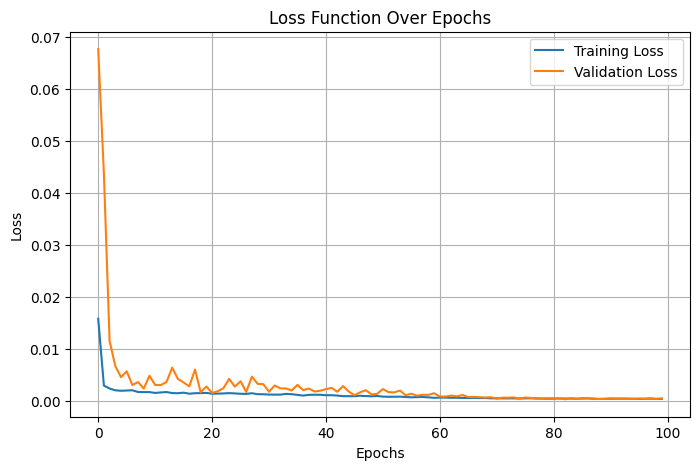

In [22]:
plot_loss(history_vgg)

In [27]:

data_dir = 'coco_dataset/test2017_small_train/'
# data_dir = 'coco_dataset/test2017_benchmark_10000/'

image_size = (256, 256)
batch_size = 4

dataset_val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    image_size=image_size,
    batch_size=batch_size,
)
colorization_dataset_val = dataset_val.map(preprocess_lab, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_size_val = int(0.2 * len(list(Path(data_dir).glob('*')))) // batch_size
train_dataset_val = colorization_dataset_val.skip(val_size_val)
val_dataset_val = colorization_dataset_val.take(val_size_val)

# Ajouter des optimisations (mélange, préchargement)
train_dataset_val = train_dataset_val.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset_val = val_dataset_val.prefetch(tf.data.experimental.AUTOTUNE)


Found 100 files.
(None, 256, 256, 1) (None, 256, 256, 2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(256, 256, 2)


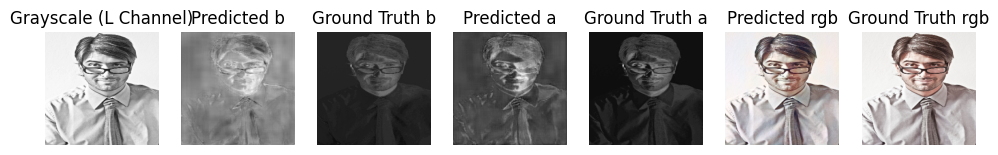

tf.Tensor(0.0001960296, shape=(), dtype=float32)
tf.Tensor(0.00014239697, shape=(), dtype=float32)
(256, 256, 2)


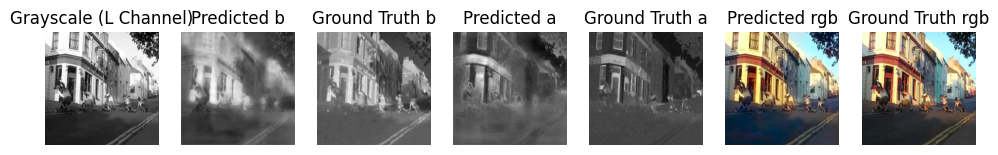

tf.Tensor(0.0016372511, shape=(), dtype=float32)
tf.Tensor(0.000679397, shape=(), dtype=float32)
(256, 256, 2)


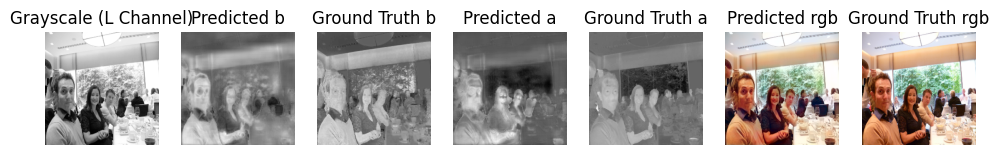

tf.Tensor(0.0010889963, shape=(), dtype=float32)
tf.Tensor(0.00076457916, shape=(), dtype=float32)
(256, 256, 2)


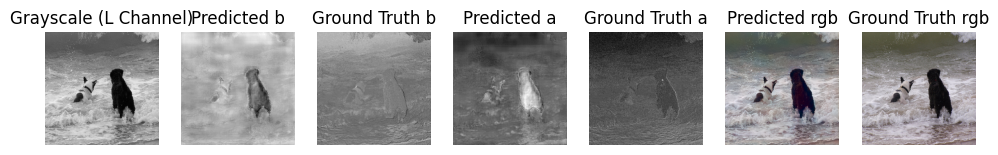

tf.Tensor(0.0005018616, shape=(), dtype=float32)
tf.Tensor(0.00020658624, shape=(), dtype=float32)


2024-12-16 18:21:44.162236: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at strided_slice_op.cc:111 : INVALID_ARGUMENT: slice index 4 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [76]:
predict_and_visualize(model_lab_vgg, val_dataset)